# Intro
Name:  

    ARISE_cloud_edge_v2

Purpose:  

    Python scripts that builds the analysis for the ARISE data of the Septemebr 19th, 2014, Flgiht # 13
    Sets up maps and background information, then proceeds to produce cloud radiative properties from 4STAR transmitted data

Calling Sequence:

    python ARISE_cloud_edge.py
  
Input:

    none at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - Sp_parameters.py : for Sp class definition, and for defining the functions used to build parameters
    - run_kisq_retrieval.py : for the retrieval functions
    - load_utils.py : for loading modis and other files
    - matplotlib
    - mpltools
    - numpy
    - scipy : for saving and reading
    - math
    - os
    - gc
    - pdb : for debugging
    - datetime
    - mpl_toolkits
    - gdal (from osgeo)
    - plotting_utils (user defined plotting routines)
    - map_utils, dependent on geopy
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - AMSR-E map files (asi-AMSR2-n6250-20140919-v5.hdf and LongitudeLatitudeGrid-n6250-Arctic.hdf)
  - MODIS retrievals
  - CALIPSO overpass file
  - C130 nav data: arise-C130-Hskping_c130_20140919_RA_Preliminary.ict
  - Probes data: ARISE-LARGE-PROBES_C130_20140919_R0.ict
  
 Modification History:
 
     Written: by Samuel LeBlanc, NASA Ames

In [1]:
%config InlineBackend.rc = {}
import matplotlib 
#matplotlib.rc_file('C:\\Users\\sleblan2\\Research\\python_codes\\file.rc')
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpltools import color
%matplotlib inline
import numpy as np, h5py
import scipy.io as sio
import scipy
import math, os, IPython
import Sp_parameters as Sp
import load_utils as lm
IPython.InteractiveShell.cache_size = 0
# set the basic directory path
from path_utils import getpath
#fp='C:/Users/sleblan2/Research/ARISE/'

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [18]:
import matplotlib.cm as cm

In [152]:
fp = getpath('ARISE')

Return path named:  ARISE /mnt/c/Users/sleblanc/Research/ARISE/


In [3]:
%matplotlib notebook

# Load varous data

## Get the AMSR data for 2014-09-19

In [4]:
famsr = fp+'AMSRE/asi-AMSR2-n6250-20140919-v5.4.hdf'
fll = fp+'AMSRE/LongitudeLatitudeGrid-n6250-Arctic.hdf'
amsr = lm.load_amsr(famsr,fll)

In [5]:
def plt_amsr(ax='None'):
    from mpl_toolkits.basemap import Basemap
    if not ax:
        fig = plt.figure()
    m = Basemap(projection='stere',lat_0=57,lon_0=-145,
               llcrnrlon=-170,llcrnrlat=53,
               urcrnrlon=-90,urcrnrlat=80 ,resolution='l')
    m.drawcountries()
    m.fillcontinents(color='grey')
    m.drawmeridians(np.linspace(-90,-200,12),labels=[0,0,0,1])
    m.drawparallels(np.linspace(53,80,10),labels=[1,0,0,0])
    x,y = m(amsr['lon'],amsr['lat'])
    clevels = np.linspace(0,100,21)
    cs = m.contourf(x,y,amsr['ice'],clevels,cmap=plt.cm.gist_earth)
    cbar = m.colorbar(cs)
    cbar.set_label('Ice concentration [\%]')
    return m

<IPython.core.display.Javascript object>


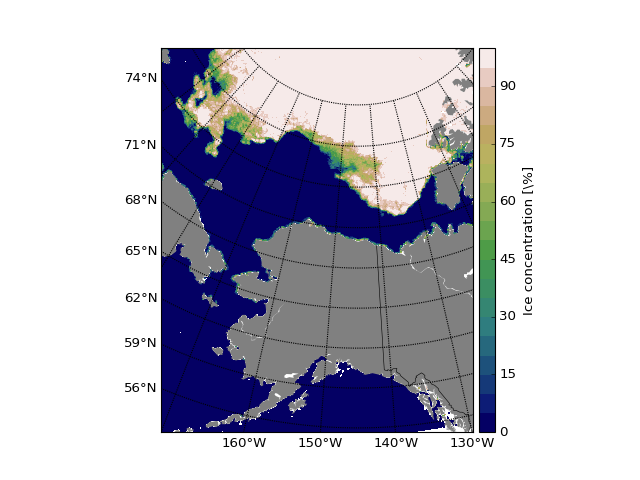

/home/sleblanc/.local/lib/python2.7/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/sleblanc/.local/lib/python2.7/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [6]:
m = plt_amsr()

In [7]:
def plt_amsr_zoom(ax='None',colorbar=True):
    from mpl_toolkits.basemap import Basemap
    if not ax:
        fig = plt.figure()
    m = Basemap(projection='stere',lat_0=72,lon_0=-128,
                llcrnrlon=-136,llcrnrlat=71,
                urcrnrlon=-117.5,urcrnrlat=75,resolution='l')
    m.drawcountries()
    m.fillcontinents(color='grey')
    m.drawmeridians(np.linspace(-115,-145,11),labels=[0,0,0,1])
    m.drawparallels(np.linspace(60,75,16),labels=[1,0,0,0])
    x,y = m(amsr['lon'],amsr['lat'])
    clevels = np.linspace(0,100,21)
    cs = m.contourf(x,y,amsr['ice'],clevels,cmap=plt.cm.gist_earth)
    if colorbar:
        cbar = m.colorbar(cs)
        cbar.set_label('Ice concentration [\%]')
    return m

<IPython.core.display.Javascript object>


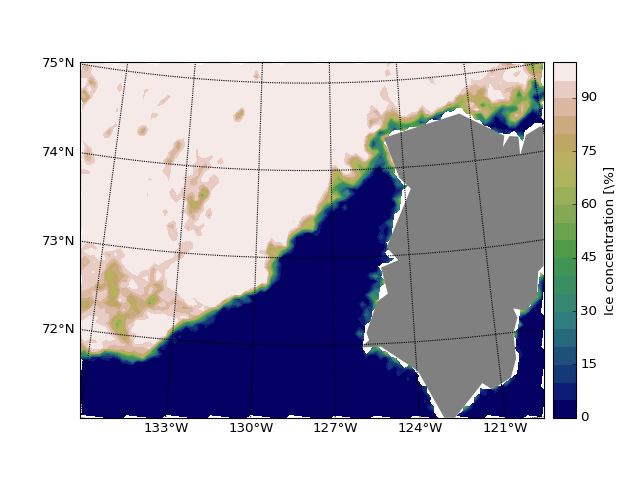

In [8]:
plt_amsr_zoom()

## Load C130 nav data

In [9]:
fnav = fp+'c130/ARISE-C130-Hskping_c130_20140919_R1.ict'
nav,nav_header = lm.load_ict(fnav,return_header=True)

('Start_UTC', 'Day_Of_Year', 'Latitude', 'Longitude', 'GPS_Altitude', 'Pressure_Altitude', 'Ground_Speed', 'True_Air_Speed', 'Indicated_Air_Speed', 'Mach_Number', 'Vertical_Speed', 'True_Heading', 'Track_Angle', 'Drift_Angle', 'Pitch_Angle', 'Roll_Angle', 'Static_Air_Temp', 'Potential_Temp', 'Dew_Point', 'Total_Air_Temp', 'IR_Surf_Temp', 'Static_Pressure', 'Cabin_Pressure', 'Wind_Speed', 'Wind_Direction', 'Solar_Zenith_Angle', 'Aircraft_Sun_Elevation', 'Sun_Azimuth', 'Aircraft_Sun_Azimuth', 'Mixing_Ratio', 'Part_Press_Water_Vapor', 'Sat_Vapor_Press_H2O', 'Sat_Vapor_Press_Ice', 'Relative_Humidity')


In [10]:
nav_header

['66,1001\r\n',
 'Project Office\r\n',
 'NSERC - National Suborbital Education and Research Center\r\n',
 'C-130 (N439NA) Data Acquisition and Distribution\r\n',
 'ARISE 2014\r\n',
 '1,1\r\n',
 '2014,09,19,2015,12,01\r\n',
 '1\r\n',
 'Start_UTC,seconds\r\n',
 '33\r\n',
 '1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1\r\n',
 '-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999\r\n',
 'Day_Of_Year,\r\n',
 'Latitude, deg\r\n',
 'Longitude, deg            \r\n',
 'GPS_Altitude, m         \r\n',
 'Pressure_Altitude, ft      \r\n',
 'Ground_Speed, m/s           \r\n',
 'True_Air_Speed, kts       \r\n',
 'Indicated_Air_Speed, kts   \r\n',
 'Mach_Number, mach         \r\n',
 'Vertical_Speed, m/s       \r\n',
 'True_Heading, deg (0-360)         \r\n',
 'Track_Angle, deg (0-360)            \r\n',
 'Drift_Angle, deg            \r\n',


In [11]:
nav['Longitude'][nav['Longitude']==0.0] = np.NaN
nav['Latitude'][nav['Latitude']<0.0] = np.NaN

<IPython.core.display.Javascript object>


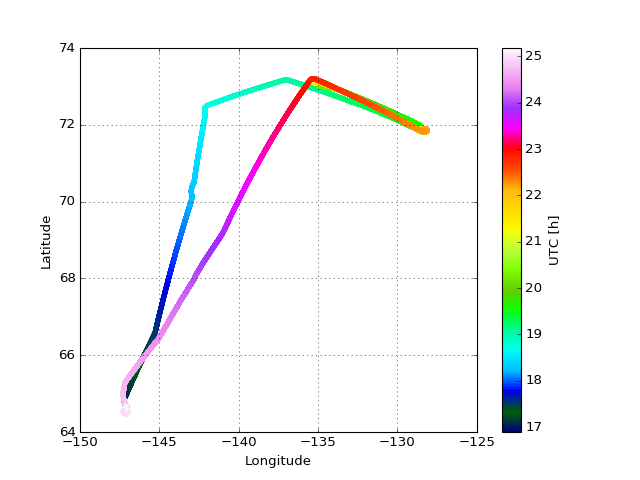

In [14]:
plt.figure()
#plt.plot(nav['Longitude'],nav['Latitude'])
ss = plt.scatter(nav['Longitude'],nav['Latitude'],c=nav['Start_UTC'],edgecolor='None',cmap=plt.cm.gist_ncar)
plt.grid()
cbar = plt.colorbar(ss)
cbar.set_label('UTC [h]')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.savefig(fp+'plots_v2/20140919_flightpath.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


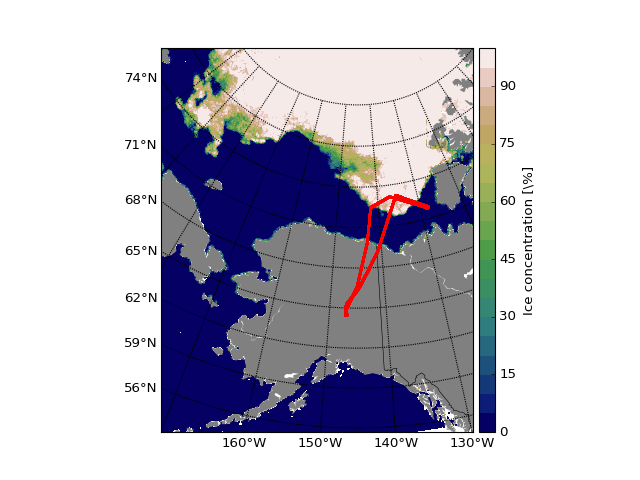

In [15]:
m = plt_amsr()
m.scatter(nav['Longitude'],nav['Latitude'],latlon=True,zorder=10,s=0.5,edgecolor='r')
plt.savefig(fp+'plots_v2/20140919_map_ice_conc.png',dpi=600,transparent=True)

In [16]:
flt = np.where((nav['Start_UTC']>19.0) & (nav['Start_UTC']<23.0) & (nav['Longitude']<0.0))[0]

<IPython.core.display.Javascript object>


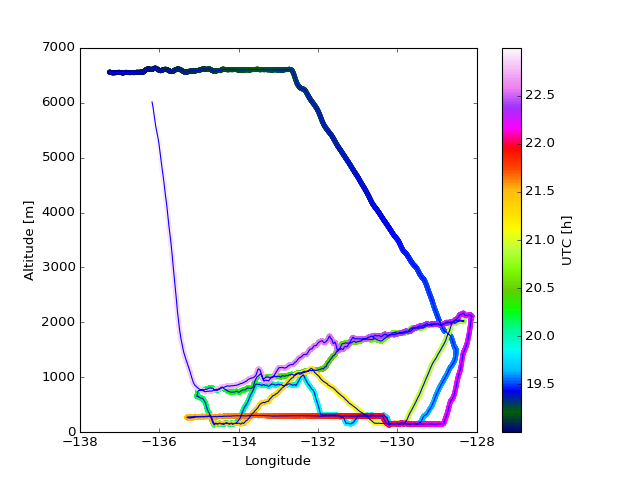

In [19]:
plt.figure()
plt.plot(nav['Longitude'][flt],nav['GPS_Altitude'][flt])
plt.xlabel('Longitude')
plt.ylabel('Altitude [m]')
plt.ylim([0,7000])
plt.xlim([-138,-128])
ss = plt.scatter(nav['Longitude'][flt],nav['GPS_Altitude'][flt],c=nav['Start_UTC'][flt],edgecolor='None',cmap=cm.gist_ncar)
cbar = plt.colorbar(ss)
cbar.set_label('UTC [h]')
plt.savefig(fp+'plots_v2/20140919_proile_alt.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


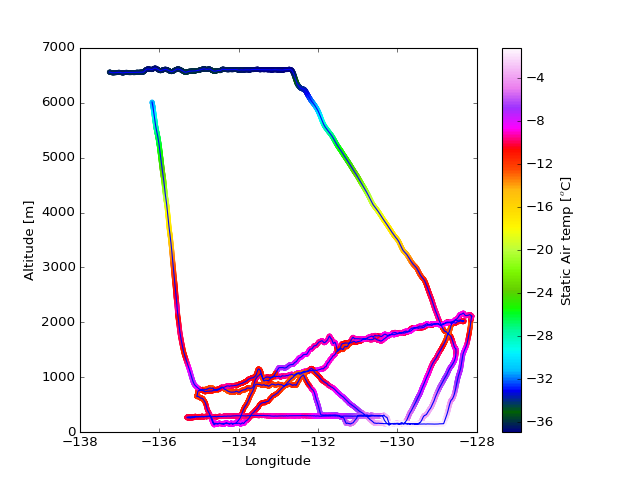

In [20]:
plt.figure()
plt.plot(nav['Longitude'][flt],nav['GPS_Altitude'][flt])
plt.xlabel('Longitude')
plt.ylabel('Altitude [m]')
plt.ylim([0,7000])
plt.xlim([-138,-128])
ss = plt.scatter(nav['Longitude'][flt],nav['GPS_Altitude'][flt],c=nav['Static_Air_Temp'][flt],edgecolor='None',cmap=cm.gist_ncar)
cbar = plt.colorbar(ss)
cbar.set_label('Static Air temp [$^{o}$C]')
plt.savefig(fp+'plots_v2/20140919_proile_alt_temp.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


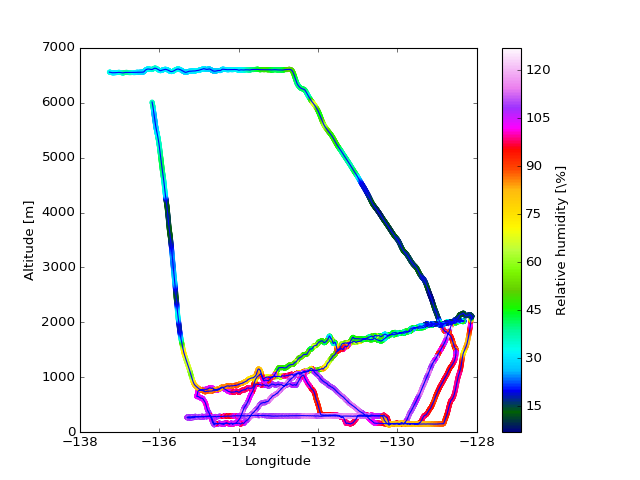

In [21]:
plt.figure()
plt.plot(nav['Longitude'][flt],nav['GPS_Altitude'][flt])
plt.xlabel('Longitude')
plt.ylabel('Altitude [m]')
plt.ylim([0,7000])
plt.xlim([-138,-128])
ss = plt.scatter(nav['Longitude'][flt],nav['GPS_Altitude'][flt],c=nav['Relative_Humidity'][flt],edgecolor='None',cmap=cm.gist_ncar)
cbar = plt.colorbar(ss)
cbar.set_label('Relative humidity [\\%]')
plt.savefig(fp+'plots_v2/20140919_proile_alt_RH.png',dpi=600,transparent=True)

## Load Cloud probe data

In [23]:
fprobe = fp+'c130/ARISE-LARGE-PROBES_C130_20140919_R2.ict'
probe,prb_header = lm.load_ict(fprobe,return_header=True)

('UTC_mid', 'Latitude_deg', 'Longitude_deg', 'PressAlt_ft', 'TWC_gm3', 'LWC1_gm3', 'LWC2_gm3', 'nCDP_cm3', 'vCDP_um3cm3', 'CDP01_dNdlogD', 'CDP02_dNdlogD', 'CDP03_dNdlogD', 'CDP04_dNdlogD', 'CDP05_dNdlogD', 'CDP06_dNdlogD', 'CDP07_dNdlogD', 'CDP08_dNdlogD', 'CDP09_dNdlogD', 'CDP10_dNdlogD', 'CDP11_dNdlogD', 'CDP12_dNdlogD', 'CDP13_dNdlogD', 'CDP14_dNdlogD', 'CDP15_dNdlogD', 'CDP16_dNdlogD', 'CDP17_dNdlogD', 'CDP18_dNdlogD', 'CDP19_dNdlogD', 'CDP20_dNdlogD', 'CDP21_dNdlogD', 'CDP22_dNdlogD', 'CDP23_dNdlogD', 'CDP24_dNdlogD', 'CDP25_dNdlogD', 'CDP26_dNdlogD', 'CDP27_dNdlogD', 'CDP28_dNdlogD', 'CDP29_dNdlogD', 'CDP30_dNdlogD')


In [24]:
prb_header

['83,1001\n',
 'Anderson, Bruce E.\n',
 'NASA Langley\n',
 'In-situ aerosol measurements from the NASA C-130\n',
 'ARISE\n',
 '1,1\n',
 '2014,09,19,2015,10,26\n',
 '1.0\n',
 'UTC_mid,Secs after midnight,Time of acquisition\n',
 '38\n',
 '1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1\n',
 '-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999,-999999\n',
 'Latitude_deg,deg,GPS Latitude\n',
 'Longitude_deg,deg,GPS Longitude\n',
 'PressAlt_ft,ft,Pressure Altitude\n',
 'TWC_gm-3, gm-3, Total Water Content from the WCM-200\n',
 'LWC1_gm-3, gm-3, Liquid Water Content from the WCM-200\n',
 'LWC2_gm-3, gm-3, Liquid Water Content from the WCM-200\n',
 'nCDP_cm-3,cm-3,Integrated Number Concentration from the DMT Cloud Droplet Pr

To Note from Lee Thornhill about this version of the archived data, received (2015-05-27 5:03 am PST):

The CDP size distributions are in dN, not dlogD. I make a mistake on that label. Usually I put size distributions into the archive as dNdlogD, but I missed a step in doing that. I will correct that with the next archive file update. 

In [25]:
flt_prb = np.where((probe['UTC_mid']>19.0) & (probe['UTC_mid']<23.0))
probe['TWC_gm3'][probe['TWC_gm3']<0.0] = np.NaN
feet2meter = 0.3048

<IPython.core.display.Javascript object>


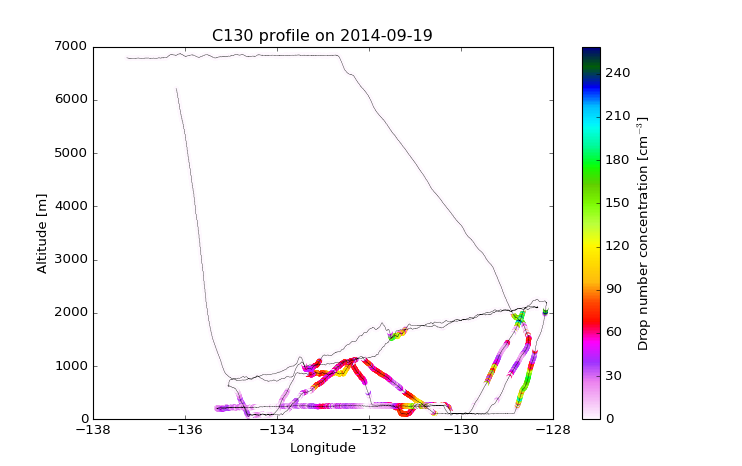

In [26]:
plt.figure()
#plt.plot(nav['Longitude'][flt],nav['GPS_Altitude'][flt])
plt.xlabel('Longitude')
plt.ylabel('Altitude [m]')
ss = plt.scatter(probe['Longitude_deg'][flt_prb],probe['PressAlt_ft'][flt_prb]*feet2meter,
                 c=probe['nCDP_cm3'][flt_prb],edgecolor='None',
                 cmap=cm.gist_ncar_r)
plt.plot(probe['Longitude_deg'][flt_prb],probe['PressAlt_ft'][flt_prb]*feet2meter,c='k',linewidth=0.3)
plt.ylim([0,7000])
plt.xlim([-138,-128])
plt.title('C130 profile on 2014-09-19')
cbar = plt.colorbar(ss)
cbar.set_label('Drop number concentration [cm$^{-3}$]')
plt.savefig(fp+'plots_v2/20140919_proile_alt_ndrop.png',dpi=600,transparent=True)

plotting of drop size distribution

In [27]:
bin_diameters = np.array([3,4,5,6,7,8,9,10,11,12,13,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50])

In [28]:
nd_dist = np.vstack((probe['CDP01_dNdlogD'],probe['CDP02_dNdlogD'],probe['CDP03_dNdlogD'],
                     probe['CDP04_dNdlogD'],probe['CDP05_dNdlogD'],probe['CDP06_dNdlogD'],
                     probe['CDP07_dNdlogD'],probe['CDP08_dNdlogD'],probe['CDP09_dNdlogD'],
                     probe['CDP10_dNdlogD'],probe['CDP11_dNdlogD'],probe['CDP12_dNdlogD'],
                     probe['CDP13_dNdlogD'],probe['CDP14_dNdlogD'],probe['CDP15_dNdlogD'],
                     probe['CDP16_dNdlogD'],probe['CDP17_dNdlogD'],probe['CDP18_dNdlogD'],
                     probe['CDP19_dNdlogD'],probe['CDP20_dNdlogD'],probe['CDP21_dNdlogD'],
                     probe['CDP22_dNdlogD'],probe['CDP23_dNdlogD'],probe['CDP24_dNdlogD'],
                     probe['CDP25_dNdlogD'],probe['CDP26_dNdlogD'],probe['CDP27_dNdlogD'],
                     probe['CDP28_dNdlogD'],probe['CDP29_dNdlogD'],probe['CDP30_dNdlogD']))

In [29]:
nd_dist[nd_dist<0.5] = np.nan

<IPython.core.display.Javascript object>


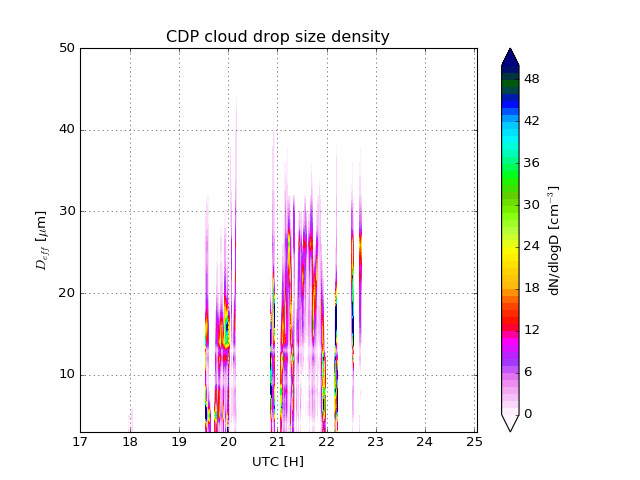

In [31]:
clevels = np.arange(0,51)
vv = plt.contourf(probe['UTC_mid'],bin_diameters,nd_dist,clevels,cmap=plt.cm.gist_ncar_r,extend='both')
cbar = plt.colorbar(vv)
cbar.set_label('dN/dlogD [cm$^{-3}$]')
plt.xlabel('UTC [H]')
plt.ylabel('$D_{eff}$ [$\\mu$m]')
plt.title('CDP cloud drop size density')
plt.grid()
plt.savefig(fp+'plots_v2/20140919_utc_dndlogd.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


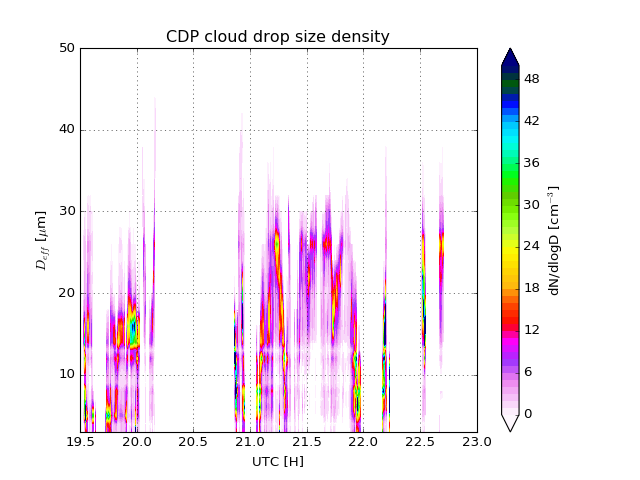

In [32]:
clevels = np.arange(0,51)
vv = plt.contourf(probe['UTC_mid'],bin_diameters,nd_dist,clevels,cmap=plt.cm.gist_ncar_r,extend='both')
cbar = plt.colorbar(vv)
cbar.set_label('dN/dlogD [cm$^{-3}$]')
plt.xlabel('UTC [H]')
plt.ylabel('$D_{eff}$ [$\\mu$m]')
plt.title('CDP cloud drop size density')
plt.xlim([19.5,23])
plt.grid()
plt.savefig(fp+'plots_v2/20140919_utc_dndlogd_zoom.png',dpi=600,transparent=True)

# Start more detailed analysis

## Convert the drop size distribution to $r_{eff}$

Trying to replicate the $r_{eff}$ equation:

$$r_{eff}=\frac{\int^{\infty}_{0}Q_{ext}(r)r^{3}n(r)dr}{\int^{\infty}_{0}Q_{ext}(r)r^{2}n(r)dr}$$


With $Q_{ext}(r)$ representing the extinction efficiency, $r$ the radius of the particle, $n(r)$ the drop size distribution

Load $Q_{ext}(r)$ for mie

For now use Q_ext = parameterized values with exponenetial decrease determined from Mie_Calc ipython notebook for lambda at 1.70 $\mu$m 

In [33]:
nd_dist.shape

(30, 29020)

In [34]:
nd_dist[:,1000]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

In [35]:
from Sp_parameters import nanmasked
def calc_ref(nd,diameter):
    " calculate the effective radius using trapezoid integration rule "
    nda,ndi = nanmasked(nd)
    popt = [ 0.87495122 ,0.22795525 ,2.08105225] # from Mie_Calc.py
    def qext(x, a, c, d):
        return a*np.exp(-c*x)+d
    if not any(ndi):
        re = np.NaN
    else:
        re = np.trapz(qext(diameter[ndi]/2.0,*popt)*(diameter[ndi]/2.0)**3.0*nda)/ \
            np.trapz(qext(diameter[ndi]/2.0,*popt)*(diameter[ndi]/2.0)**2.0*nda)
    return re

In [36]:
print calc_ref(nd_dist[:,14000],bin_diameters)

5.721650492520953


In [37]:
ref = np.zeros(len(nd_dist[0,:]))
for i in xrange(len(nd_dist[0,:])):
    ref[i] = calc_ref(nd_dist[:,i],bin_diameters)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


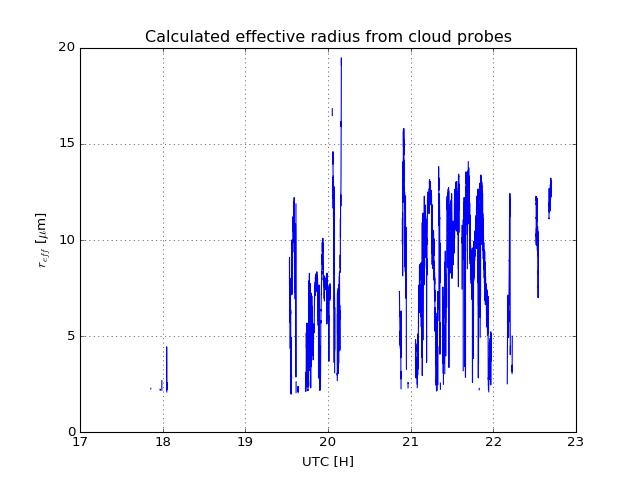

In [38]:
plt.plot(probe['UTC_mid'],ref)
plt.title('Calculated effective radius from cloud probes')
plt.xlabel('UTC [H]')
plt.ylabel('$r_{eff}$ [$\\mu$m]')
plt.grid()
plt.savefig(fp+'plots_v2/20140919_utc_probes_ref.png',dpi=600,transparent=True)

In [40]:
probe_ref = Sp.smooth(ref,10,nan=False,old=True)

<IPython.core.display.Javascript object>


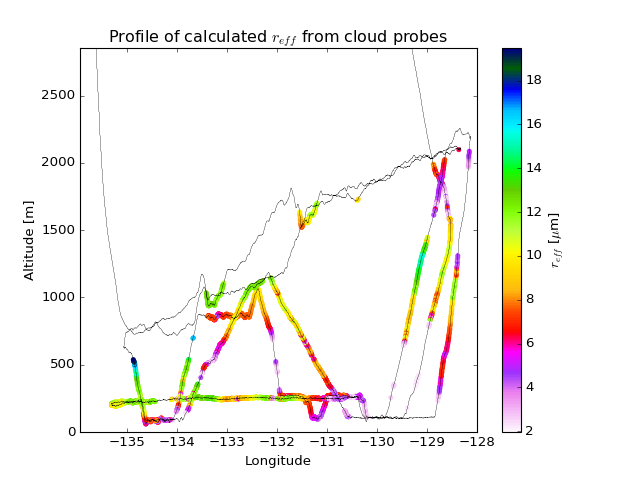

In [153]:
plt.figure()
#plt.plot(nav['Longitude'][flt],nav['GPS_Altitude'][flt])
plt.xlabel('Longitude')
plt.ylabel('Altitude [m]')
ss = plt.scatter(probe['Longitude_deg'][flt_prb],probe['PressAlt_ft'][flt_prb]*feet2meter,
                 c=ref[flt_prb],edgecolor='None',
                 cmap=cm.gist_ncar_r)
plt.plot(probe['Longitude_deg'][flt_prb],probe['PressAlt_ft'][flt_prb]*feet2meter,c='k',linewidth=0.3)
plt.ylim([0,7000])
plt.xlim([-138,-128])
plt.title('Profile of calculated $r_{eff}$ from cloud probes')
cbar = plt.colorbar(ss)
cbar.set_label('$r_{eff}$ [$\\mu$m]')
plt.savefig(fp+'plots_v2/20140919_proile_alt_ref_calc.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


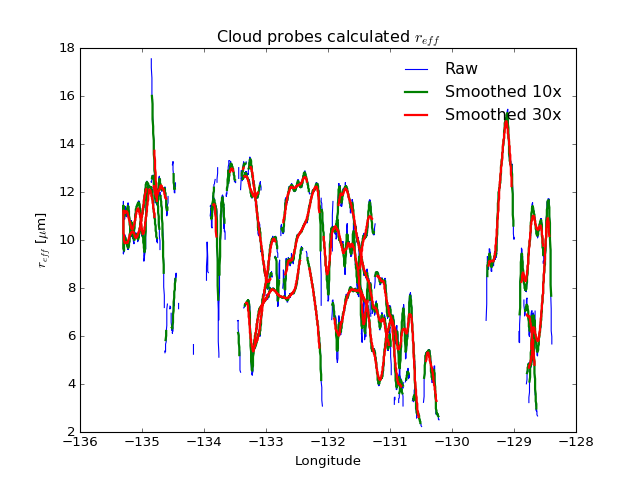

In [44]:
plt.figure()
plt.plot(probe['Longitude_deg'][flt_prb],probe_ref[flt_prb],label='Raw')
plt.plot(probe['Longitude_deg'][flt_prb],Sp.smooth(probe_ref[flt_prb],10,nan=False,old=True),label='Smoothed 10x',linewidth=2)
plt.plot(probe['Longitude_deg'][flt_prb],Sp.smooth(probe_ref[flt_prb],30,nan=False,old=True),label='Smoothed 30x',linewidth=2)
plt.title('Cloud probes calculated $r_{eff}$')
plt.xlabel('Longitude')
plt.ylabel('$r_{eff}$ [$\\mu$m]')
plt.legend(frameon=False)
plt.savefig(fp+'plots_v2/20140919_lon_ref_calc.png',dpi=600,transparent=True)

# Load other retrieved and radiative properties

## Load the MODIS cloud properties

Get the data from MODIS for the proper day of year

In [45]:
from datetime import datetime
datetime(2014,9,19).timetuple().tm_yday

262

In [46]:
fmodis_aqua = fp+'MODIS/MYD06_L2.A2014262.1955.006.2014282222048.hdf'
fmodis_aqua_geo = fp+'MODIS/MYD03.A2014262.1955.006.2014272205731.hdf'
fmodis_terra = fp+'MODIS/MOD06_L2.A2014262.2115.006.2015077072247.hdf'
fmodis_terra_geo = fp+'MODIS/MOD03.A2014262.2115.006.2014272205802.hdf'
fviirs = fp+'' #not yet

In [47]:
aqua,aqua_dicts = lm.load_modis(fmodis_aqua_geo,fmodis_aqua)

Outputting the Geo subdatasets:
0: [4060x2708] Scan Offset MODIS_Swath_Type_GEO (8-bit integer)
1: [4060x2708] Track Offset MODIS_Swath_Type_GEO (8-bit integer)
2: [4060x2708] Height Offset MODIS_Swath_Type_GEO (8-bit integer)
3: [2030x1354] Height MODIS_Swath_Type_GEO (16-bit integer)
4: [2030x1354] SensorZenith MODIS_Swath_Type_GEO (16-bit integer)
5: [2030x1354] SensorAzimuth MODIS_Swath_Type_GEO (16-bit integer)
6: [2030x1354] Range MODIS_Swath_Type_GEO (16-bit unsigned integer)
7: [2030x1354] SolarZenith MODIS_Swath_Type_GEO (16-bit integer)
8: [2030x1354] SolarAzimuth MODIS_Swath_Type_GEO (16-bit integer)
9: [2030x1354] Land/SeaMask MODIS_Swath_Type_GEO (8-bit unsigned integer)
10: [2030x1354] WaterPresent MODIS_Swath_Type_GEO (8-bit unsigned integer)
11: [2030x1354] gflags MODIS_Swath_Type_GEO (8-bit unsigned integer)
12: [2030x1354] Latitude (32-bit floating-point)
13: [2030x1354] Longitude (32-bit floating-point)
14: [4060x2708] Scan Offset (8-bit integer)
15: [4060x2708] Trac

99: [2030x1354] Cloud_Water_Path_Uncertainty_1621 mod06 (16-bit integer)
100: [2030x1354] Cloud_Water_Path_Uncertainty_16 mod06 (16-bit integer)
101: [2030x1354] Cloud_Water_Path_Uncertainty_37 mod06 (16-bit integer)
102: [2030x1354] Above_Cloud_Water_Vapor_094 mod06 (16-bit integer)
103: [2030x1354] IRW_Low_Cloud_Temperature_From_COP mod06 (16-bit integer)
104: [2030x1354] Cloud_Phase_Optical_Properties mod06 (8-bit integer)
105: [2030x1354] Cloud_Multi_Layer_Flag mod06 (8-bit integer)
106: [2030x1354] Cirrus_Reflectance mod06 (16-bit integer)
107: [2030x1354] Cirrus_Reflectance_Flag mod06 (8-bit integer)
108: [406x270x2] Cloud_Mask_5km mod06 (8-bit integer)
109: [406x270x10] Quality_Assurance_5km mod06 (8-bit integer)
110: [2030x1354x2] Cloud_Mask_1km mod06 (8-bit integer)
111: [12x7] Extinction_Efficiency_Ice mod06 (32-bit floating-point)
112: [12x7] Asymmetry_Parameter_Ice mod06 (32-bit floating-point)
113: [12x7] Single_Scatter_Albedo_Ice mod06 (32-bit floating-point)
114: [18x7] 

Running through modis values: [########################################]100% -- Done! 
['tau', 'etau', 'cth', 'multi_layer', 'sza', 'lon', 'qa', 'phase', 'eref', 'lat', 'ref']


In [48]:
terra,terra_dicts = lm.load_modis(fmodis_terra_geo,fmodis_terra)

Outputting the Geo subdatasets:
0: [4060x2708] Scan Offset MODIS_Swath_Type_GEO (8-bit integer)
1: [4060x2708] Track Offset MODIS_Swath_Type_GEO (8-bit integer)
2: [4060x2708] Height Offset MODIS_Swath_Type_GEO (8-bit integer)
3: [2030x1354] Height MODIS_Swath_Type_GEO (16-bit integer)
4: [2030x1354] SensorZenith MODIS_Swath_Type_GEO (16-bit integer)
5: [2030x1354] SensorAzimuth MODIS_Swath_Type_GEO (16-bit integer)
6: [2030x1354] Range MODIS_Swath_Type_GEO (16-bit unsigned integer)
7: [2030x1354] SolarZenith MODIS_Swath_Type_GEO (16-bit integer)
8: [2030x1354] SolarAzimuth MODIS_Swath_Type_GEO (16-bit integer)
9: [2030x1354] Land/SeaMask MODIS_Swath_Type_GEO (8-bit unsigned integer)
10: [2030x1354] WaterPresent MODIS_Swath_Type_GEO (8-bit unsigned integer)
11: [2030x1354] gflags MODIS_Swath_Type_GEO (8-bit unsigned integer)
12: [2030x1354] Latitude (32-bit floating-point)
13: [2030x1354] Longitude (32-bit floating-point)
14: [4060x2708] Scan Offset (8-bit integer)
15: [4060x2708] Trac

110: [2030x1354x2] Cloud_Mask_1km mod06 (8-bit integer)
111: [12x7] Extinction_Efficiency_Ice mod06 (32-bit floating-point)
112: [12x7] Asymmetry_Parameter_Ice mod06 (32-bit floating-point)
113: [12x7] Single_Scatter_Albedo_Ice mod06 (32-bit floating-point)
114: [18x7] Extinction_Efficiency_Liq mod06 (32-bit floating-point)
115: [18x7] Asymmetry_Parameter_Liq mod06 (32-bit floating-point)
116: [18x7] Single_Scatter_Albedo_Liq mod06 (32-bit floating-point)
117: [2030x1354x2] Cloud_Mask_SPI mod06 (16-bit integer)
118: [2030x1354x3] Retrieval_Failure_Metric mod06 (16-bit integer)
119: [2030x1354x3] Retrieval_Failure_Metric_16 mod06 (16-bit integer)
120: [2030x1354x3] Retrieval_Failure_Metric_37 mod06 (16-bit integer)
121: [2030x1354x3] Retrieval_Failure_Metric_1621 mod06 (16-bit integer)
122: [2030x1354x6] Atm_Corr_Refl mod06 (16-bit integer)
123: [2030x1354x9] Quality_Assurance_1km mod06 (8-bit integer)
124: [406x270] Latitude (32-bit floating-point)
125: [406x270] Longitude (32-bit floa

Running through modis values: [########################################]100% -- Done! 
['tau', 'etau', 'cth', 'multi_layer', 'sza', 'lon', 'qa', 'phase', 'eref', 'lat', 'ref']


In [51]:
terra_dicts['tau']

{'ALGORITHMPACKAGEACCEPTANCEDATE': 'June 1997',
 'ALGORITHMPACKAGEMATURITYCODE': 'at-launch',
 'ALGORITHMPACKAGENAME': 'ATBD-MOD-04 and ATBD-MOD-05',
 'ALGORITHMPACKAGEVERSION': '2',
 'ALGORITHM_VERSION_CLOUD_PHASE_IR': '1',
 'ALGORITHM_VERSION_CLOUD_PROPERTY_VIS': '1',
 'ALGORITHM_VERSION_CLOUD_TOP_PROPERTY_IR': '1',
 'ANCILLARYINPUTPOINTER': 'MOD03.A2014262.2115.006.2014272205802.hdf',
 'ANCILLARYINPUTTYPE': 'Geolocation',
 'ASSOCIATEDINSTRUMENTSHORTNAME': 'MODIS',
 'ASSOCIATEDPLATFORMSHORTNAME': 'Terra',
 'ASSOCIATEDSENSORSHORTNAME': 'MODIS',
 'AUTOMATICQUALITYFLAG': 'Passed',
 'AUTOMATICQUALITYFLAGEXPLANATION': 'Passed: >10% useable; Failed: <10% useable',
 'Cell_Across_Swath_Sampling': '1, 1354, 1',
 'Cell_Along_Swath_Sampling': '1, 2030, 1',
 'CirrusCloudDetectedPct_IR': '   30.29',
 'Clear_Sky_Restoral_Status': 'y',
 'CloudPhaseUncertainPct_IR': '   54.48',
 'Collection_4_Phase_Used': 'n',
 'DAYNIGHTFLAG': 'Day',
 'DESCRREVISION': '6.0',
 'EASTBOUNDINGCOORDINATE': '-103.59909772

In [52]:
flt_aqua = np.where(nav['Start_UTC']<19.9)

<IPython.core.display.Javascript object>


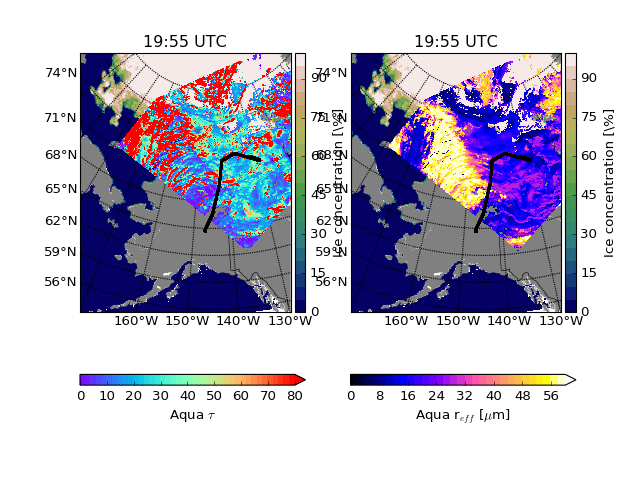

In [53]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
m = plt_amsr(ax=ax1)
clevels = np.linspace(0,80,41)
cc = m.contourf(aqua['lon'],aqua['lat'],aqua['tau'],clevels,latlon=True,cmap=plt.cm.rainbow,extend='max',zorder=10)
cbar = plt.colorbar(cc,orientation='horizontal')
cbar.set_label('Aqua $\\tau$')
m.scatter(nav['Longitude'][flt_aqua],nav['Latitude'][flt_aqua],latlon=True,zorder=10,s=0.5,edgecolor='k')
plt.title('19:55 UTC')

ax2 = fig.add_subplot(1,2,2)
m2 = plt_amsr(ax=ax2)
clevels2 = np.linspace(0,60,31)
cc = m2.contourf(aqua['lon'],aqua['lat'],aqua['ref'],clevels2,latlon=True,cmap=plt.cm.gnuplot2,extend='max',zorder=10)
cbar = plt.colorbar(cc,orientation='horizontal')
cbar.set_label('Aqua r$_{eff}$ [$\\mu$m]')
m2.scatter(nav['Longitude'][flt_aqua],nav['Latitude'][flt_aqua],latlon=True,zorder=10,s=0.5,edgecolor='k')
plt.title('19:55 UTC')

plt.savefig(fp+'plots_v2/20140919_map_aqua.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


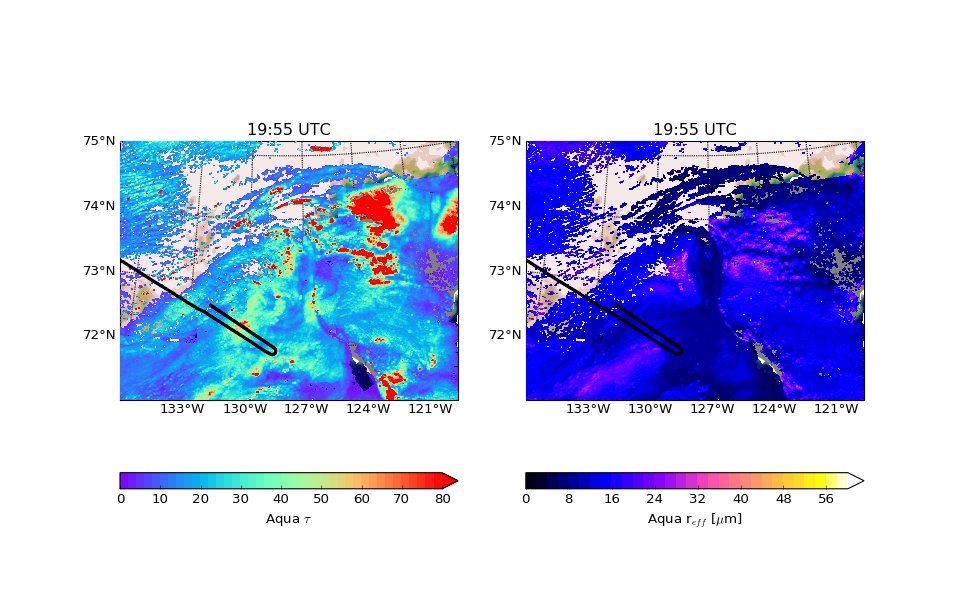

In [54]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
m = plt_amsr_zoom(ax=ax1,colorbar=False)
clevels = np.linspace(0,80,41)
cc = m.contourf(aqua['lon'],aqua['lat'],aqua['tau'],clevels,latlon=True,cmap=plt.cm.rainbow,extend='max',zorder=10)
cbar = plt.colorbar(cc,orientation='horizontal')
cbar.set_label('Aqua $\\tau$')
m.scatter(nav['Longitude'][flt_aqua],nav['Latitude'][flt_aqua],latlon=True,zorder=10,s=0.5,edgecolor='k')
plt.title('19:55 UTC')

ax2 = fig.add_subplot(1,2,2)
m2 = plt_amsr_zoom(ax=ax2,colorbar=False)
clevels2 = np.linspace(0,60,31)
cc = m2.contourf(aqua['lon'],aqua['lat'],aqua['ref'],clevels2,latlon=True,cmap=plt.cm.gnuplot2,extend='max',zorder=10)
cbar = plt.colorbar(cc,orientation='horizontal')
cbar.set_label('Aqua r$_{eff}$ [$\\mu$m]')
m2.scatter(nav['Longitude'][flt_aqua],nav['Latitude'][flt_aqua],latlon=True,zorder=10,s=0.5,edgecolor='k')
plt.title('19:55 UTC')

plt.savefig(fp+'plots_v2/20140919_map_zoom_aqua.png',dpi=600,transparent=True)

In [55]:
flt_terra = np.where(nav['Start_UTC']<21.25)

<IPython.core.display.Javascript object>


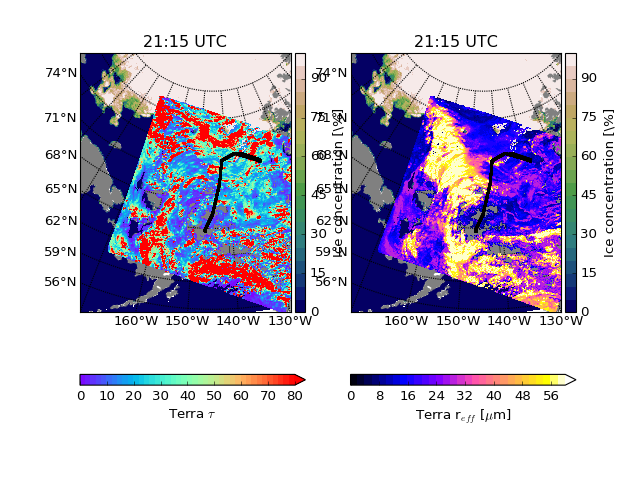

In [56]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
m = plt_amsr(ax=ax1)
clevels = np.linspace(0,80,41)
cc = m.contourf(terra['lon'],terra['lat'],terra['tau'],clevels,latlon=True,cmap=plt.cm.rainbow,extend='max',zorder=10)
cbar = plt.colorbar(cc,orientation='horizontal')
cbar.set_label('Terra $\\tau$')
m.scatter(nav['Longitude'][flt_terra],nav['Latitude'][flt_terra],latlon=True,zorder=10,s=0.5,edgecolor='k')
plt.title('21:15 UTC')

ax2 = fig.add_subplot(1,2,2)
m2 = plt_amsr(ax=ax2)
clevels2 = np.linspace(0,60,31)
cc = m2.contourf(terra['lon'],terra['lat'],terra['ref'],clevels2,latlon=True,cmap=plt.cm.gnuplot2,extend='max',zorder=10)
cbar = plt.colorbar(cc,orientation='horizontal')
cbar.set_label('Terra r$_{eff}$ [$\\mu$m]')
m2.scatter(nav['Longitude'][flt_terra],nav['Latitude'][flt_terra],latlon=True,zorder=10,s=0.5,edgecolor='k')
plt.title('21:15 UTC')

plt.savefig(fp+'plots_v2/20140919_map_terra.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


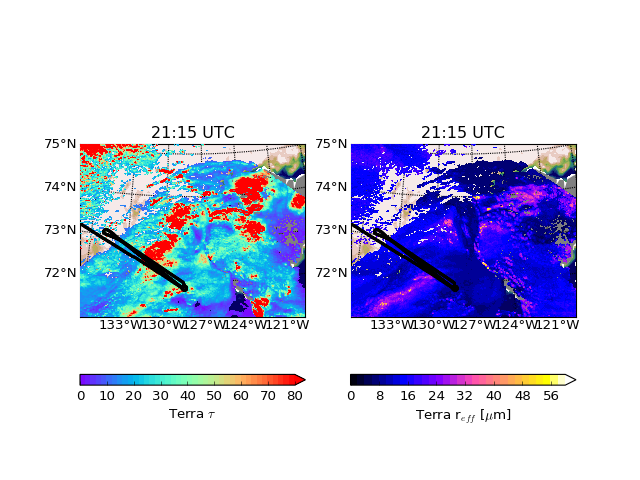

In [57]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
m = plt_amsr_zoom(ax=ax1,colorbar=False)
clevels = np.linspace(0,80,41)
cc = m.contourf(terra['lon'],terra['lat'],terra['tau'],clevels,latlon=True,cmap=plt.cm.rainbow,extend='max',zorder=10)
cbar = plt.colorbar(cc,orientation='horizontal')
cbar.set_label('Terra $\\tau$')
m.scatter(nav['Longitude'][flt_terra],nav['Latitude'][flt_terra],latlon=True,zorder=10,s=0.5,edgecolor='k')
plt.title('21:15 UTC')

ax2 = fig.add_subplot(1,2,2)
m2 = plt_amsr_zoom(ax=ax2,colorbar=False)
clevels2 = np.linspace(0,60,31)
cc = m2.contourf(terra['lon'],terra['lat'],terra['ref'],clevels2,latlon=True,cmap=plt.cm.gnuplot2,extend='max',zorder=10)
cbar = plt.colorbar(cc,orientation='horizontal')
cbar.set_label('Terra r$_{eff}$ [$\\mu$m]')
m2.scatter(nav['Longitude'][flt_terra],nav['Latitude'][flt_terra],latlon=True,zorder=10,s=0.5,edgecolor='k')
plt.title('21:15 UTC')

plt.savefig(fp+'plots_v2/20140919_map_zoom_terra.png',dpi=600,transparent=True)

## Load MERRA Reanalysis

In [114]:
fmerra = fp+'MERRA/MERRA300.prod.assim.inst6_3d_ana_Nv.20140919.SUB.hdf'
merra,merra_dict = lm.load_hdf_sd(fmerra)

Reading file: /mnt/c/Users/sleblanc/Research/ARISE/MERRA/MERRA300.prod.assim.inst6_3d_ana_Nv.20140919.SUB.hdf
/mnt/c/Users/sleblanc/Research/ARISE/MERRA/MERRA300.prod.assim.inst6_3d_ana_Nv.20140919.SUB.hdf 1
print test
  ps: (('time', 'latitude', 'longitude'), (4, 88, 113), 5, 3)
No FillValue on ps
  qv: (('time', 'levels', 'latitude', 'longitude'), (4, 72, 88, 113), 5, 9)
No FillValue on qv
  v: (('time', 'levels', 'latitude', 'longitude'), (4, 72, 88, 113), 5, 8)
No FillValue on v
  longitude: (('longitude',), (113,), 6, 1)
No missing_value on longitude
No FillValue on longitude
  delp: (('time', 'levels', 'latitude', 'longitude'), (4, 72, 88, 113), 5, 5)
No FillValue on delp
  levels: (('levels',), (72,), 6, 4)
No missing_value on levels
No FillValue on levels
  u: (('time', 'levels', 'latitude', 'longitude'), (4, 72, 88, 113), 5, 7)
No FillValue on u
  t: (('time', 'levels', 'latitude', 'longitude'), (4, 72, 88, 113), 5, 6)
No FillValue on t
  time: (('time',), (4,), 6, 0)
No missi

In [115]:
merra_dict['delp']

{'comments': 'Unknown1 variable comment\x00',
 'grid_name': 'grid-1\x00',
 'grid_type': 'linear\x00',
 'long_name': 'Layer pressure thickness\x00',
 'missing_value': 999999986991104.0,
 'time_statistic': 'instantaneous\x00',
 'units': '\x00'}

In [116]:
def p2alt(p):
    "convert pressure (in hpa) to altitude (in meter)"
    return (1.0-np.power(p/1013.25,1.0/5.25588))/2.25577E-5

In [117]:
p2alt(merra['levels'][-10])

1508.6957062039219

<IPython.core.display.Javascript object>


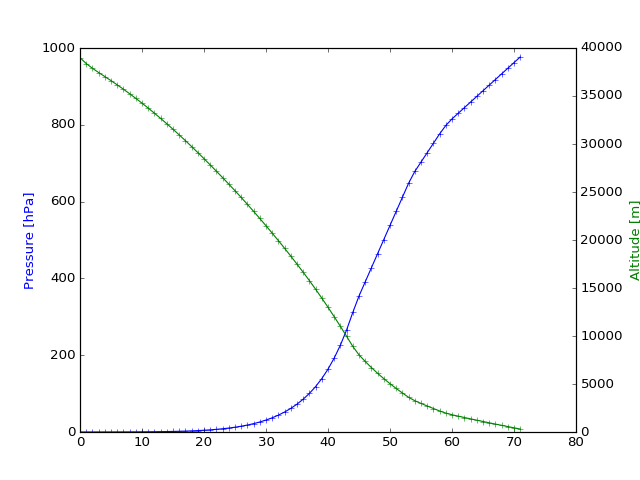

In [118]:
fig,ax = plt.subplots(1,1)
plt.plot(merra['levels'],'b+-')
ax2 = ax.twinx()
ax2.plot(p2alt(merra['levels']),'g+-')
ax2.set_ylabel('Altitude [m]',color='g')
ax.set_ylabel('Pressure [hPa]',color='b')

<IPython.core.display.Javascript object>


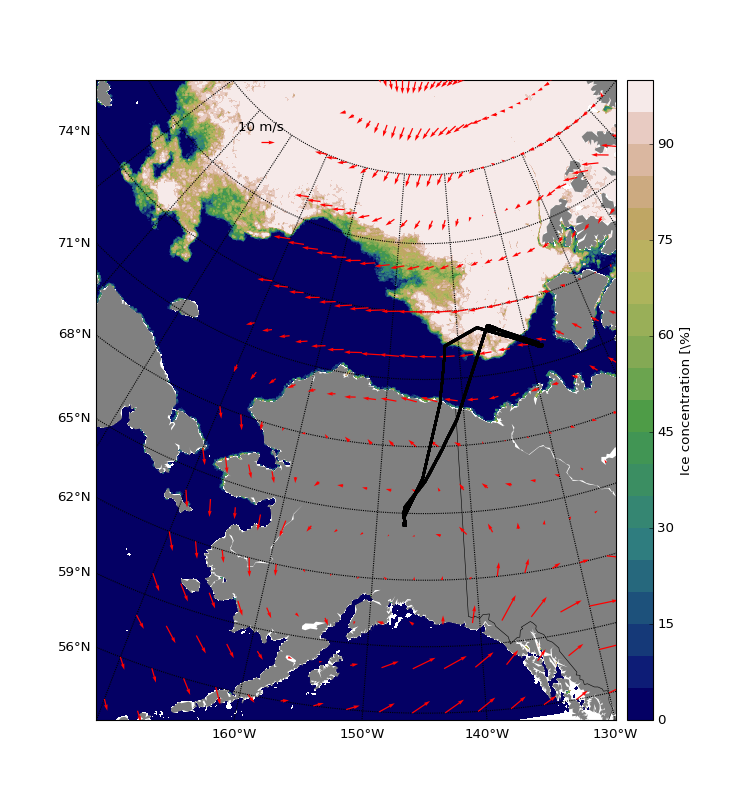

In [119]:
plt.figure(figsize=(5,10))
m = plt_amsr()
mlon = merra['latitude'][:,np.newaxis]*0.0+merra['longitude'][np.newaxis,:]
mlat = merra['latitude'][:,np.newaxis]+merra['longitude'][np.newaxis,:]*0.0
x,y = m(mlon,mlat)
q = plt.quiver(x[::4,::4],y[::4,::4],merra['u'][3,-10,::4,::4],merra['v'][3,-10,::4,::4],zorder=10,color='r')
x0,y0 = m(-185,79)
plt.quiverkey(q,x0,y0,10,'10 m/s',coordinates='data',color='r')
m.scatter(nav['Longitude'],nav['Latitude'],latlon=True,zorder=10,s=0.5,edgecolor='k')
#m.contour(mlon,mlat,merra['delp'][3,-10,:,:],latlon=True,zorder=10)
plt.savefig(fp+'plots_v2/20140919_map_wind.png',dpi=600,transparent=True)

In [120]:
merra['longitude'][50:78]

array([-136.66633606, -135.99966431, -135.33299255, -134.6663208 ,
       -133.99964905, -133.33297729, -132.66630554, -131.99963379,
       -131.33296204, -130.66629028, -129.99961853, -129.33294678,
       -128.66627502, -127.99960327, -127.33293152, -126.66625977,
       -125.99958801, -125.33291626, -124.66624451, -123.99957275,
       -123.332901  , -122.66622925, -121.9995575 , -121.33288574,
       -120.66621399, -119.99954224, -119.33287048, -118.66619873])

In [121]:
print merra['latitude'].shape
print merra['v'].shape

(88,)
(4, 72, 88, 113)


<IPython.core.display.Javascript object>


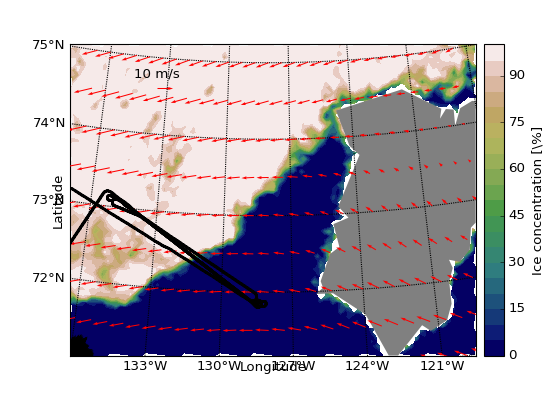

In [125]:
plt.figure(figsize=(7,5))
m = plt_amsr_zoom()
mlon = merra['latitude'][40:60,np.newaxis]*0.0+merra['longitude'][np.newaxis,50:78]
mlat = merra['latitude'][40:60,np.newaxis]+merra['longitude'][np.newaxis,50:78]*0.0
x,y = m(mlon,mlat)
q = plt.quiver(x,y,merra['u'][3,-10,40:60,50:78],merra['v'][3,-10,40:60,50:78],zorder=10,color='r')
x0,y0 = m(-133.5,74.6)
plt.quiverkey(q,x0,y0,10,'10 m/s',coordinates='data',color='r')
m.scatter(nav['Longitude'],nav['Latitude'],latlon=True,zorder=10,s=0.5,edgecolor='k')
plt.savefig(fp+'plots_v2/20140919_map_zoom_wind.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


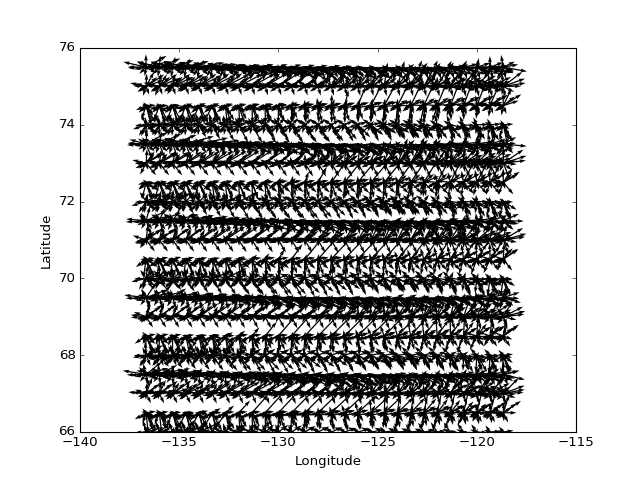

In [127]:
plt.figure()
plt.quiver(mlon,mlat,merra['u'][3,-10,:,:],merra['v'][3,-10,:,:])
plt.ylabel('Latitude')
plt.xlabel('Longitude')

## Plotting of profiles

First get the indices in ice concentration linked to the flight path

In [128]:
import map_utils as mu

Create a lat lon slice to use for correlating the sea ice concentration

In [129]:
points_lat = [73.2268,71.817716]
points_lon = [-135.3189167,-128.407833]

In [130]:
from scipy import interpolate
flat = interpolate.interp1d([0,100],points_lat)
flon = interpolate.interp1d([0,100],points_lon)
path_lat = flat(np.arange(100))
path_lon = flon(np.arange(100))

In [132]:
ind = np.zeros((2,len(path_lat)), dtype=np.int)
for i,x in enumerate(path_lat):
    y = path_lon[i]
    ind[:,i] = np.unravel_index(np.nanargmin(np.square(amsr['lat']-x)+np.square(amsr['lon']-360.0-y)),amsr['lat'].shape)

<IPython.core.display.Javascript object>


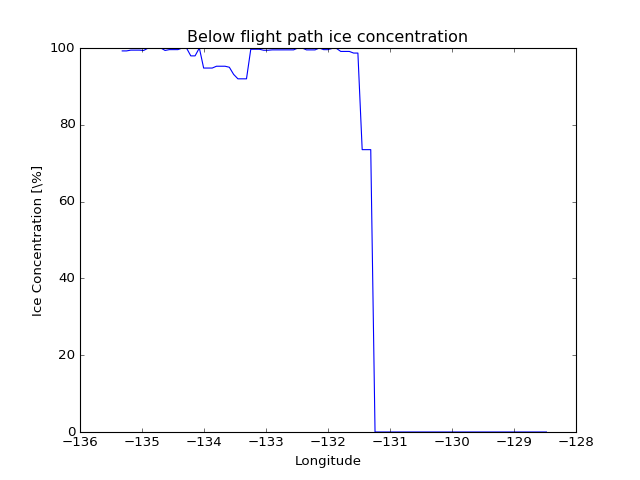

In [133]:
plt.figure()
plt.plot(path_lon,amsr['ice'][ind[0,:],ind[1,:]])
plt.ylabel('Ice Concentration [\%]')
plt.xlabel('Longitude')
plt.title('Below flight path ice concentration')

<IPython.core.display.Javascript object>


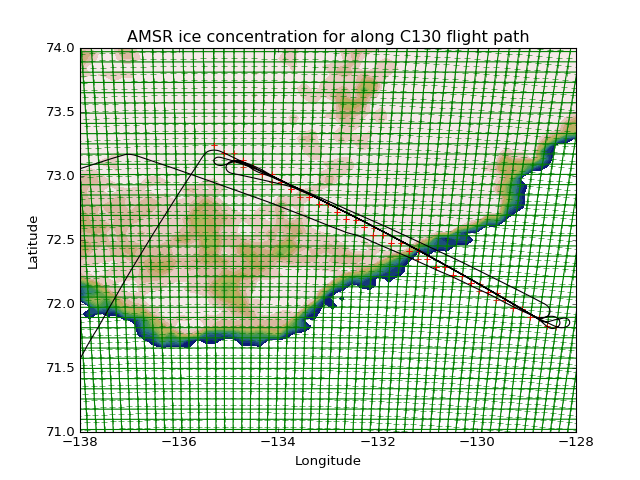

In [134]:
plt.figure()
plt.plot(amsr['lon'].reshape(amsr['lon'].size)-360,amsr['lat'].reshape(amsr['lon'].size),'g+-')
plt.plot(amsr['lon'][ind[0,:],ind[1,:]]-360.0,amsr['lat'][ind[0,:],ind[1,:]],'r+')
plt.plot(nav['Longitude'],nav['Latitude'],'k')
plt.xlim([-138,-128])
plt.ylim([71,74])
clevels = np.linspace(0,100,21)
plt.contourf(amsr['lon']-360.0,amsr['lat'],amsr['ice'],clevels,cmap=plt.cm.gist_earth)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('AMSR ice concentration for along C130 flight path')

<IPython.core.display.Javascript object>


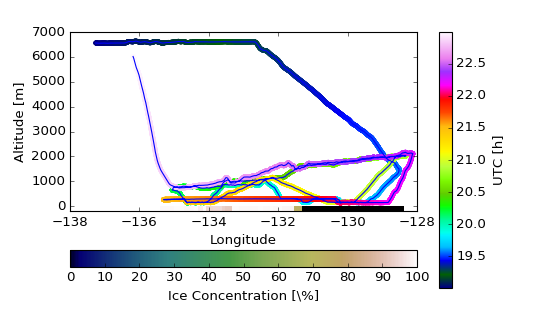

In [137]:
plt.figure(figsize=(7,4))
plt.plot(nav['Longitude'][flt],nav['GPS_Altitude'][flt])
plt.xlabel('Longitude')
plt.ylabel('Altitude [m]')
plt.ylim([-200,7000])
plt.xlim([-138,-128])
ss = plt.scatter(nav['Longitude'][flt],nav['GPS_Altitude'][flt],c=nav['Start_UTC'][flt],edgecolor='None',cmap=cm.gist_ncar)
si = plt.scatter(path_lon,path_lon*0.0-100,c=amsr['ice'][ind[0,:],ind[1,:]],
                 marker='s',edgecolor='None',cmap=cm.gist_earth,s=30,clip_on=False)
cbar = plt.colorbar(ss)
cbar.set_label('UTC [h]')
cbar = plt.colorbar(si,orientation='horizontal')
cbar.set_label('Ice Concentration [\%]')

plt.savefig(fp+'plots_v2/20140919_proile_alt_ice.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


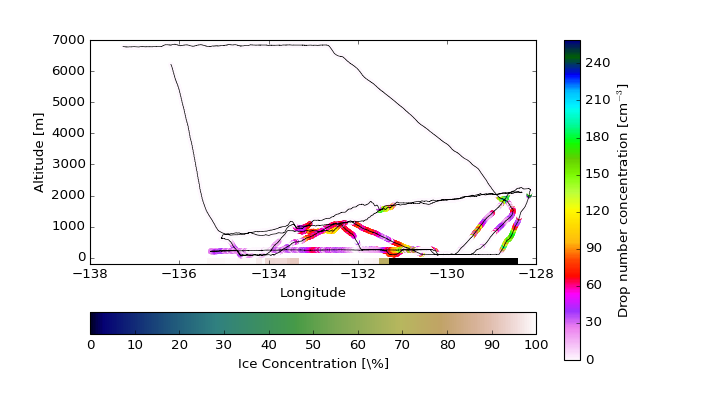

In [139]:
plt.figure(figsize=(9,5))
plt.plot(probe['Longitude_deg'][flt_prb],probe['PressAlt_ft'][flt_prb]*feet2meter,'k',linewidth=0.6)
plt.xlabel('Longitude')
plt.ylabel('Altitude [m]')
plt.ylim([-200,7000])
plt.xlim([-138,-128])
#ss = plt.scatter(nav['Longitude'][flt],nav['GPS_Altitude'][flt],c=nav['Start_UTC'][flt],edgecolor='None',cmap=cm.gist_ncar)
si = plt.scatter(path_lon,path_lon*0.0-100,c=amsr['ice'][ind[0,:],ind[1,:]],
                 marker='s',edgecolor='None',cmap=cm.gist_earth,s=30,clip_on=False)
#cbar = plt.colorbar(ss)
#cbar.set_label('UTC [h]')
ss = plt.scatter(probe['Longitude_deg'][flt_prb],probe['PressAlt_ft'][flt_prb]*feet2meter,
                 c=probe['nCDP_cm3'][flt_prb],edgecolor='None',
                 cmap=cm.gist_ncar_r)
cbar = plt.colorbar(ss)
cbar.set_label('Drop number concentration [cm$^{-3}$]')

cbar = plt.colorbar(si,orientation='horizontal')
cbar.set_label('Ice Concentration [\%]')

plt.savefig(fp+'plots_v2/20140919_profile_alt_cloud_ice.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


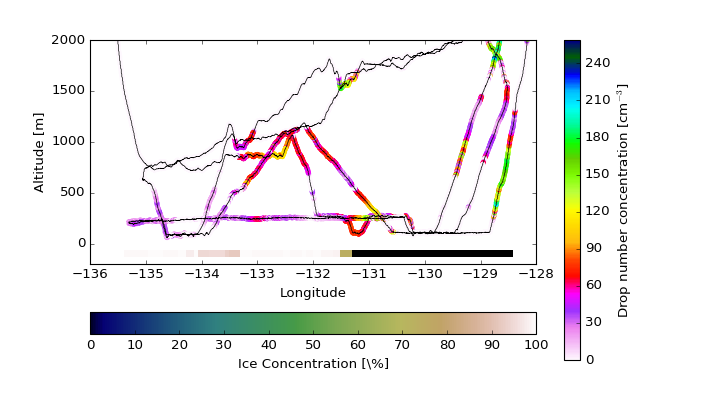

In [141]:
plt.figure(figsize=(9,5))
plt.plot(probe['Longitude_deg'][flt_prb],probe['PressAlt_ft'][flt_prb]*feet2meter,'k',linewidth=0.6)
plt.xlabel('Longitude')
plt.ylabel('Altitude [m]')
plt.ylim([-200,2000])
plt.xlim([-136,-128])
#ss = plt.scatter(nav['Longitude'][flt],nav['GPS_Altitude'][flt],c=nav['Start_UTC'][flt],edgecolor='None',cmap=cm.gist_ncar)
si = plt.scatter(path_lon,path_lon*0.0-100,c=amsr['ice'][ind[0,:],ind[1,:]],
                 marker='s',edgecolor='None',cmap=cm.gist_earth,s=40,clip_on=False)
#cbar = plt.colorbar(ss)
#cbar.set_label('UTC [h]')
ss = plt.scatter(probe['Longitude_deg'][flt_prb],probe['PressAlt_ft'][flt_prb]*feet2meter,
                 c=probe['nCDP_cm3'][flt_prb],edgecolor='None',
                 cmap=cm.gist_ncar_r)
cbar = plt.colorbar(ss)
cbar.set_label('Drop number concentration [cm$^{-3}$]')

cbar = plt.colorbar(si,orientation='horizontal')
cbar.set_label('Ice Concentration [\%]')

plt.savefig(fp+'plots_v2/20140919_proile_zoom_alt_cloud_ice.png',dpi=600,transparent=True)

Now get a MERRA profile of winds on top of this.

## Load the 4STAR data

In [142]:
fstar = fp+'starzen/20140919starzen.mat'
star = sio.loadmat(fstar)
star.keys()

['Str',
 'sza',
 'm_ray',
 'toggle',
 'pitch',
 'Tst',
 'fwhm',
 'nirt',
 'O3h',
 'NO2col',
 'Headng',
 'RH',
 'Pst',
 'nirheader',
 'iset',
 'sd_aero_crit',
 'nirTint_rad',
 'dark',
 'nirVdettemp',
 'Elstep',
 'nircols',
 'sunaz',
 'O3col',
 'nirfilen',
 'f',
 't',
 'c0mod',
 'rate',
 'program_version',
 'sat_time',
 'sat_set_vis',
 'visheader',
 'nirTint',
 'filename',
 'rads',
 'nirsat_pixel',
 'Md',
 'aeronetcols',
 'visAVG',
 'Zn',
 'AZstep',
 't_rad',
 'darkstd',
 'QdVtot',
 'nirAVG',
 'w',
 'ELcorr',
 'sat_nir',
 'visVdettemp_C',
 'El_deg',
 'skyresp',
 'Lon',
 'AZ_deg',
 'visrow_labels',
 'm_H2O',
 'c0err',
 'viscols',
 'visTint_rad',
 'sat_vis',
 'aerosolcols',
 'vissat_pixel',
 'visfilen',
 'c0',
 'Tprecon_C',
 'raw',
 '__header__',
 'rawcorr',
 'sat_ij',
 'sunel',
 'visTint',
 'Tbox_C',
 'QdVtb',
 'rad',
 'QdVlr',
 'nirVdettemp_C',
 'visVdettemp',
 'nirrow_labels',
 'm_aero',
 'Tbox',
 'Tprecon',
 'ng',
 'note',
 'RHprecon_percent',
 'Lat',
 '__version__',
 'roll',
 'vist',


<IPython.core.display.Javascript object>


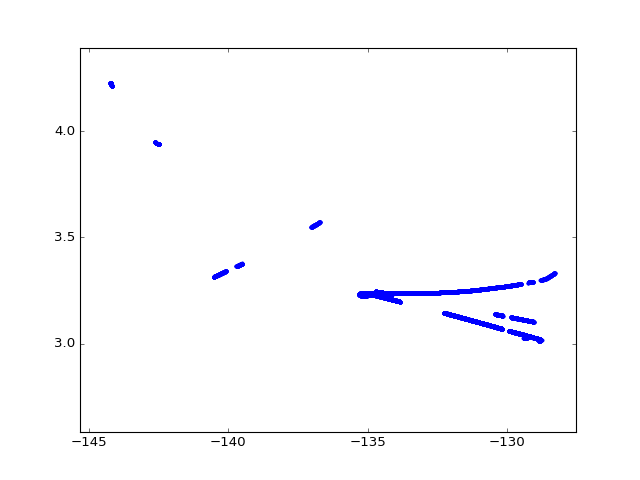

In [157]:
plt.figure()
plt.plot(star['Lon'],star['m_aero'],'.')

In [143]:
star['iset']

array([[   6],
       [  12],
       [  18],
       ...,
       [7911],
       [7914],
       [7922]], dtype=uint16)

In [144]:
star['utc'] = lm.toutc(lm.mat2py_time(star['t']))
star['utcr'] = lm.toutc(lm.mat2py_time(star['t_rad']))

In [145]:
flt_star_ice = np.where((star['utcr']>19.0) & (star['utcr']<23.0) & (star['Lon'][star['iset']]<-133) & (star['Alt'][star['iset']]<900.0))[0]
flt_star_wat = np.where((star['utcr']>19.0) & (star['utcr']<23.0) & (star['Lon'][star['iset']]>-133) & (star['Alt'][star['iset']]<900.0))[0]

In [146]:
star['utc'].shape

(7927,)

In [147]:
flt_star_ice

array([   0,    0,    0, ..., 1572, 1572, 1572])

<IPython.core.display.Javascript object>


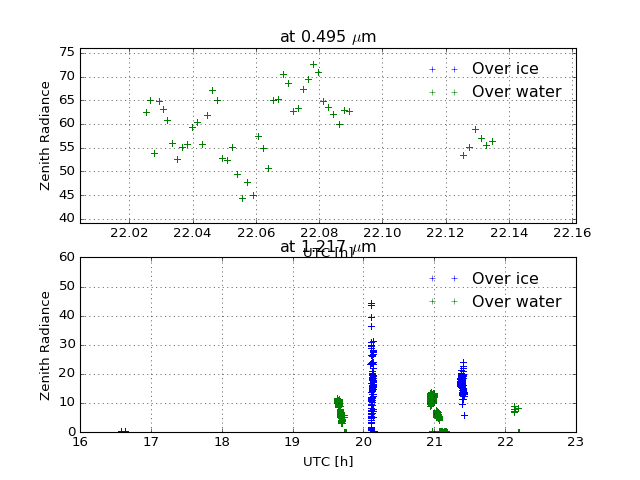

In [151]:
fig = plt.figure()
fig.add_subplot(2,1,1)
plt.plot(star['utcr'][flt_star_ice],star['rads'][flt_star_ice,400],'b+',label='Over ice')
plt.plot(star['utcr'][flt_star_wat],star['rads'][flt_star_wat,400],'g+',label='Over water')
plt.ylabel('Zenith Radiance')
plt.xlabel('UTC [h]')
plt.ylim([0,250])
plt.title('at %.3f $\mu$m' % star['w'][0,400])
plt.grid()
plt.legend(frameon=False)
fig.add_subplot(2,1,2)
plt.plot(star['utcr'][flt_star_ice],star['rads'][flt_star_ice,1200],'b+',label='Over ice')
plt.plot(star['utcr'][flt_star_wat],star['rads'][flt_star_wat,1200],'g+',label='Over water')
plt.ylabel('Zenith Radiance')
plt.xlabel('UTC [h]')
plt.ylim([0,60])
plt.grid()
plt.title('at %.3f $\mu$m' % star['w'][0,1200])
plt.legend(frameon=False)

### Define 4STAR zenith data as an SP object and prepare for calculations

In [19]:
import Sp_parameters as Sp
reload(Sp)

<module 'Sp_parameters' from 'Sp_parameters.pyc'>

In [20]:
star['good'] = np.where((star['utcr']>19.0) & (star['utcr']<23.0) & (star['Alt'][star['iset'][:,0],0]<900.0))[0]
len(star['good'])

1479

In [21]:
stars = Sp.Sp(star)
stars.params()

1556 1556
in rads
(1954L, 1556L) 2 1556
1 in ui
(1954L, 1556L)
Running Parameters


### Now load the different luts

In [22]:
sice = sio.idl.readsav(fp+'model/sp_v2_20140919_ice_4STAR.out')
swat = sio.idl.readsav(fp+'model/sp_v2_20140919_wat_4STAR.out')
print sice.keys()
print swat.keys()

['tau', 'ab', 'pw', 'sp_irrdn', 'sp', 'zenlambda', 'sza', 'zout', 'sp_irrup', 'z', 'ref']
['tau', 'ab', 'pw', 'sp_irrdn', 'sp', 'zenlambda', 'sza', 'zout', 'sp_irrup', 'z', 'ref']


In [23]:
lutice = Sp.Sp(sice)

1556 1556
in sp
(2L, 1556L, 2L, 35L, 24L)
(2L, 1556L, 2L, 35L, 24L)


In [24]:
lutwat = Sp.Sp(swat)

1556 1556
in sp
(2L, 1556L, 2L, 35L, 24L)
(2L, 1556L, 2L, 35L, 24L)


In [25]:
lutice.params()
lutice.param_hires()
lutice.sp_hires()

Running Parameters
Running parameter hires
(111L,)
(59L,)
Running interpolation on params: [########################################]100% -- Done! 
(111L,)
(59L,)
Running interpolation: [########################################]100% -- Done! 
Overwriting the current sp, tau, and ref with the new high resolution values


In [26]:
lutwat.params()
lutwat.param_hires()
lutwat.sp_hires()

Running Parameters
Running parameter hires
(111L,)
(59L,)
Running interpolation on params: [########################################]100% -- Done! 
(111L,)
(59L,)
Running interpolation: [########################################]100% -- Done! 
Overwriting the current sp, tau, and ref with the new high resolution values


## Plot the 4STAR zenith radiance measurement and model

In [27]:
from Sp_parameters import nanmasked, closestindex, norm2max

In [25]:
def plot_greys(fig=None,ax=None):
    " Plotting of grey regions that indicates the different wavelenght regions where the parameters are defined. "
    cl = '#DDDDDD'
    plt.axvspan(1000,1077,color=cl) #eta1
    plt.axvspan(1192,1194,color=cl) #eta2
    plt.axvspan(1492,1494,color=cl) #eta3
    plt.axvspan(1197,1199,color=cl); plt.axvspan(1235,1237,color=cl);  #eta4
    plt.axvspan(1248,1270,color=cl) #eta5
    plt.axvspan(1565,1644,color=cl) #eta6
    plt.axvspan(1000,1050,color=cl) #eta7
    plt.axvspan(1493,1600,color=cl) #eta8
    plt.axvspan(1000,1077,color=cl) #eta9
    plt.axvspan(1200,1300,color=cl) #eta10
    plt.axvspan(530 ,610 ,color=cl) #eta11
    plt.axvspan(1039,1041,color=cl) #eta12
    plt.axvspan(999 ,1001,color=cl); plt.axvspan(1064,1066,color=cl);  #eta13
    plt.axvspan(599 ,601 ,color=cl); plt.axvspan(869 ,871 ,color=cl);  #eta14
    plt.axvspan(1565,1634,color=cl); #eta15

In [28]:
print stars.utc[fltice[200]]
print stars.utc[fltwat[200]]

NameError: name 'fltice' is not defined

In [29]:
stars.norm.shape

(1954L, 1556L)

In [30]:
stars.sp.shape

(1954L, 1556L)

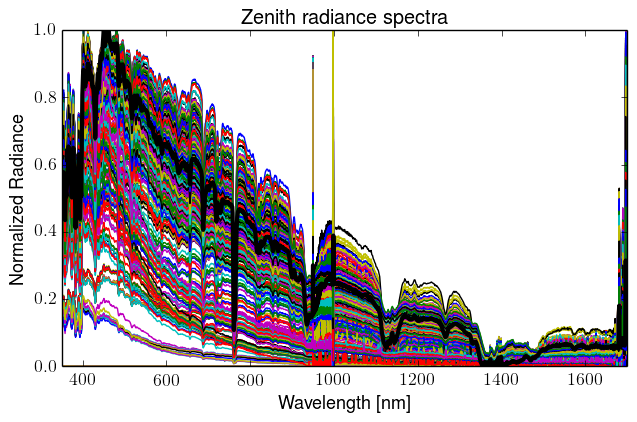

In [67]:
fig,ax = plt.subplots()
ax.plot(stars.wvl,stars.norm[fltice,:].T)
ax.set_title('Zenith radiance spectra')
ax.set_ylabel('Normalized Radiance')
ax.set_xlabel('Wavelength [nm]')
ax.set_xlim([350,1700])
ax.set_ylim([0,1.0])
ax.plot(stars.wvl,stars.norm[fltice[400],:],'k',linewidth=3)

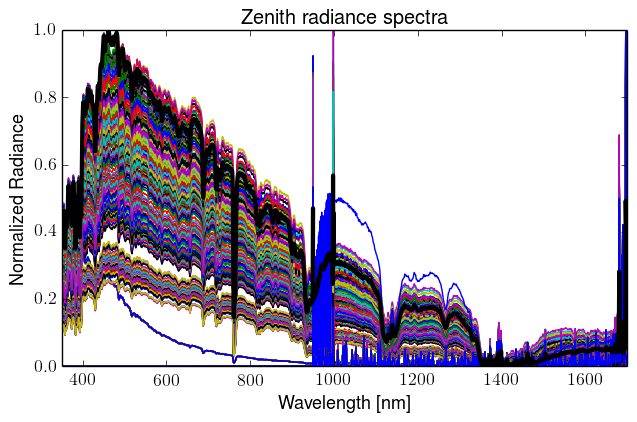

In [74]:
fig,ax = plt.subplots()
ax.plot(stars.wvl,stars.norm[fltwat,:].T)
ax.set_title('Zenith radiance spectra')
ax.set_ylabel('Normalized Radiance')
ax.set_xlabel('Wavelength [nm]')
ax.set_xlim([350,1700])
ax.set_ylim([0,1.0])
ax.plot(stars.wvl,stars.norm[fltwat[400],:],'k',linewidth=3)

In [31]:
lutice.norm

array([[[[[  8.40216339e-01,   6.72085524e-01,   4.71506834e-01, ...,
             1.94129035e-01,   1.98774546e-01,   2.03068942e-01],
          [  8.53674114e-01,   6.97393656e-01,   5.12759328e-01, ...,
             1.80223808e-01,   1.84655398e-01,   1.89059302e-01],
          [  8.62197995e-01,   7.12644398e-01,   5.36828458e-01, ...,
             1.95018753e-01,   2.00112253e-01,   2.04707086e-01],
          ..., 
          [             nan,              nan,              nan, ...,
                        nan,              nan,              nan],
          [             nan,              nan,              nan, ...,
                        nan,              nan,              nan],
          [             nan,              nan,              nan, ...,
                        nan,              nan,              nan]],

         [[  1.03599966e+00,   1.02790725e+00,   1.02183127e+00, ...,
             1.02918351e+00,   1.02977431e+00,   1.03030694e+00],
          [  1.03659916e+00,  

In [32]:
lutice.tau.shape

(111L,)

In [33]:
lutice.tau[25]

15.0

In [34]:
lutice.sp.shape

(2L, 1556L, 2L, 59L, 111L)

In [36]:
spwat = stars.norm[fltwat[400],:]
spwat[1066:1072] = np.nan
spwat[979] = np.nan

In [37]:
spice = stars.norm[fltice[400],:]
spwat[1066:1072] = np.nan

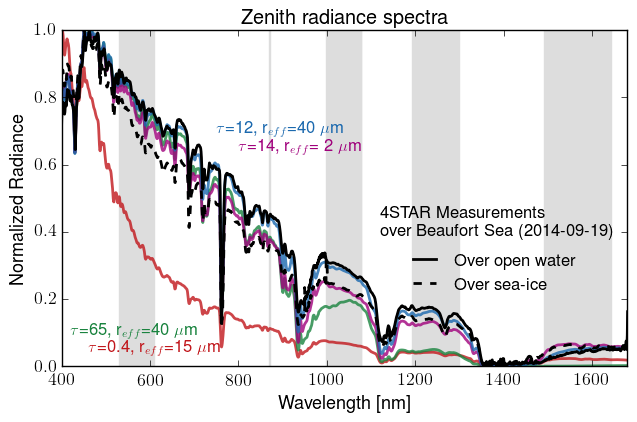

In [66]:
fig,ax = plt.subplots()
ax.plot(stars.wvl,Sp.smooth(stars.norm[fltwat[400],:],2),'k-')
ax.plot(stars.wvl,Sp.smooth(stars.norm[fltice[400],:],2),'k--')
ax.set_title('Zenith radiance spectra')
ax.set_ylabel('Normalized Radiance')
ax.set_xlabel('Wavelength [nm]')
ax.set_xlim([400,1680])
ax.set_ylim([0,1.0])
plot_greys()
lines = [('$\\tau$=%2.1f, r$_{eff}$=%2.0f $\\mu$m' % (lutice.tau[2],lutice.ref[13]),'Reds',0,[13,13],2,[460,0.009]),
         ('$\\tau$=%2.0f, r$_{eff}$=%2.0f $\\mu$m' % (lutice.tau[75],lutice.ref[38]),'Greens',0,[38,34],75,[420,0.02]),
         ('$\\tau$=%2.0f, r$_{eff}$=%2.0f $\\mu$m'% (lutice.tau[24],lutice.ref[0]),'RdPu',0,[0,13],24,[800,0.14]),
         ('$\\tau$=%2.0f, r$_{eff}$=%2.0f $\\mu$m' % (lutice.tau[22],lutice.ref[38]),'Blues',0,[38,38],22,[750,0.152])]
iwvls = lutice.iwvls
lutice.wv = lutice.wvl
for names,cmap,iphase,irefs,itau,pos in lines:
    rf = range(irefs[0],irefs[1])
    cmm = plt.cm._generate_cmap(cmap,int(len(rf)*2.25))
    cl = plt.cm.get_cmap(cmap)(200)
    ax.plot(lutice.wvl,lutice.sp[iphase,:,0,irefs[0],itau]/np.nanmax(lutice.sp[iphase,:,0,irefs[0],itau]),color=cl,linewidth=2,alpha=0.8)
    #for ir,r in enumerate(rf):
    #    ax.plot(lutice.wvl,lutice.norm[iphase,:,0,r,itau],color=cmm(ir),linewidth=2,alpha=0.8)
    ax.text(pos[0],pos[1]/0.22,names,color=cl)
    #[alow,ahigh] = plot_line_gradients(ax,lutice,names,cmap,iphase,irefs,itau,iwvls,pos,normalize=True)
ax.text(1120,0.39,'4STAR Measurements\n over Beaufort Sea (2014-09-19)')
ax.plot(stars.wvl,Sp.smooth(spwat,2),'k-',linewidth=2, label='Over open water')
ax.plot(stars.wvl,Sp.smooth(spice,2),'k--',linewidth=2, label='Over sea-ice')
ax.legend(frameon=False,loc=(0.6,0.2),fontsize=12)
plt.savefig(fp+'plots/20140919_4STAR_mod_meas_zenrad.png',dpi=600,transparent=True)
plt.savefig(fp+'plots/20140919_4STAR_mod_meas_zenrad.pdf', format='pdf', dpi=900)

In [ ]:
# set up plotting of a few of the zenith radiance spectra
def pltzen(fig=None,ax=None, tit='Zenith spectra'):
    "Plotting of zenith measurements in radiance units"
    if ax is None: 
        fig,ax = plt.subplots()
        doaxes = True
    else:
        doaxes = False
    ax.plot(sm.nm[mask],rad,lw=2, c='k', label='4STAR measured at: '+str(time_ref))
    if doaxes:
        plt.title(tit)
        plt.ylabel('Radiance [Wm$^{-2}$nm$^{-1}$sr$^{-1}$]')
        plt.xlabel('Wavelength [nm]')
        plt.xlim([350,1700])
        plt.ylim([0,0.22])
        plt.legend(frameon=False)
    #plot_url = py.plot_mpl(fig)
    return fig,ax

def norm(fig=None,ax=None):
    "Plotting of zenith measurements in normalized radiance"
    if ax is None:
        fig,ax = plt.subplots()
        doaxes = True
    else:
        doaxes = False
    ax.plot(sm.nm[mask],norm2max(rad),lw=2, c='k', label='4STAR measured at: '+str(time_ref))
    if doaxes:
        plt.title('Zenith radiance spectra')
        plt.ylabel('Normalized Radiance')
        plt.xlabel('Wavelength [nm]')
        plt.xlim([350,1700])
        plt.ylim([0,1.0])
        plt.legend(frameon=False)
    #plot_url = py.plot_mpl(fig)
    return fig,ax

def dashlen(dashlength,dashseperation,fig=plt.gcf()):
    """ Build a list of dash length that fits within the current figure or figure denoted by fig, 
        each dash is length dashlength, with its centers at dashseperation """
    totallen = fig.get_figwidth()
    numdash = int(totallen/dashseperation)*2
    f=lambda i: dashlength if i%2==0 else dashseperation-dashlength
    return tuple([f(i) for i in range(numdash)])

In [78]:
def plot_line_gradients(ax,s,names,cmap,iphase,irefs,itau,iwvls,pos,normalize=False):
    """ Make multiple lines on the subplot ax of the spectra s, for the case defined by names with the cmap
      for one particular phase (iphase), range of refs (irefs) and at one itau. Returns the axis handles for the thin and thick ref """
    rf = range(irefs[0],irefs[1])
    colors = plt.cm._generate_cmap(cmap,int(len(rf)*2.25))
    for ir in rf:
        if not(normalize):
            a1 = ax.plot(s.wv,s.sp[iphase,iwvls,0,ir,itau],
                         color=(0.2,0.2,0.2),
                         lw=1.0+1.4*float(ir)/irefs[1])
            ax.plot(s.wv,s.sp[iphase,iwvls,0,ir,itau],
                     color=colors(ir),
                     lw=1.0+1.3*float(ir)/irefs[1])
            ax.text(pos[0],pos[1],names,color=colors(irefs[1]))
        else:
            a1 = ax.plot(s.wv,norm2max(s.sp[iphase,iwvls,0,ir,itau]),
                         color=(0.2,0.2,0.2),
                         lw=1.0+1.4*float(ir)/irefs[1])
            ax.plot(s.wv,norm2max(s.sp[iphase,iwvls,0,ir,itau]),
                     color=colors(ir),
                     lw=1.0+1.3*float(ir)/irefs[1])    
            ax.text(pos[0],pos[1]/0.22,names,color=colors(irefs[1]))
        if ir == rf[0]:
            alow = a1
        if ir == rf[-1]:
            ahigh = a1
    return [alow,ahigh]

In [ ]:
fig,ax=norm()
lines = [('Liquid Cloud Model, $\\tau$=0.5','Reds',0,[0,13],1,[420,0.01]),
         ('Ice Cloud Model, $\\tau$=0.5','Greens',1,[13,34],1,[380,0.02]),
         ('Liquid Cloud Model, $\\tau$=10','RdPu',0,[0,13],9,[700,0.16]),
         ('Ice Cloud Model, $\\tau$=10','Blues',1,[13,34],9,[750,0.15])]
for names,cmap,iphase,irefs,itau,pos in lines:
    [alow,ahigh] = plot_line_gradients(ax,s,names,cmap,iphase,irefs,itau,iwvls,pos,normalize=True)
plt.legend([alow[0],ahigh[0]],lbl,
           frameon=False,loc=7,prop={'size':10})
ax.text(600,0.19/0.22,'4STAR Measurement')
norm(fig,ax)
plt.axvspan(350,1700,color='#FFFFFF')
plot_greys()
plt.savefig(fp+'plots/zen_spectra_model.png',dpi=600,transparent=True)

### Now load and run the retrieval on 4STAR data subset

In [29]:
import run_kisq_retrieval as rk
reload(rk)

<module 'run_kisq_retrieval' from 'run_kisq_retrieval.pyc'>

In [30]:
(stars.icetau,stars.iceref,stars.icephase,stars.iceki) = rk.run_retrieval(stars,lutice,force_liq=True)

Retrieval progress over times: [########################################]100% -- Done! 


In [31]:
(stars.wattau,stars.watref,stars.watphase,stars.watki) = rk.run_retrieval(stars,lutwat,force_liq=True)

Retrieval progress over times: [########################################]100% -- Done! 


### Plot the resulting retrieved properties

Assure that the retrieved properties make sense first, remove bad data

In [32]:
stars.icetau[stars.icetau>=80] = np.nan
stars.wattau[stars.wattau>=80] = np.nan

In [33]:
stars.iceref[stars.iceref>=60] = np.nan
stars.watref[stars.watref>=60] = np.nan
stars.iceref[stars.iceref==17] = np.nan
stars.watref[stars.watref==17] = np.nan
#stars.iceref[stars.iceref==30] = np.nan
#stars.watref[stars.watref==30] = np.nan
#stars.iceref[stars.iceref==40] = np.nan
#stars.watref[stars.watref==40] = np.nan

Now smooth over data to reduce variability

In [34]:
stars.icetau = Sp.smooth(stars.icetau[:],5,nan=False)
stars.wattau = Sp.smooth(stars.wattau[:],5,nan=False)

In [35]:
stars.iceref = Sp.smooth(stars.iceref[:],5,nan=False)
stars.watref = Sp.smooth(stars.watref[:],5,nan=False)

Plot the resulting figures

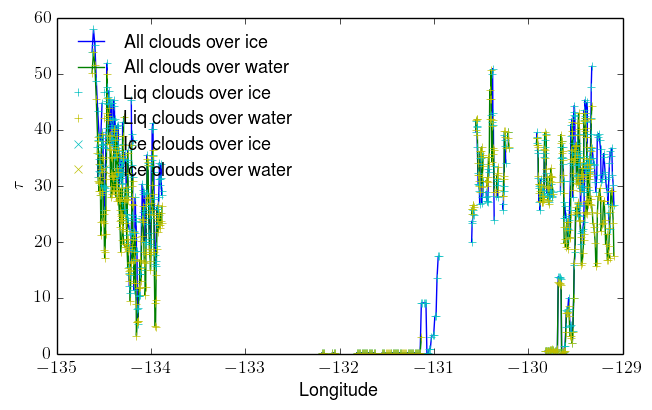

In [89]:
plt.plot(stars.lon,stars.icetau,label='All clouds over ice')
plt.plot(stars.lon,stars.wattau,label='All clouds over water')
plt.plot(stars.lon[stars.icephase==0],stars.icetau[stars.icephase==0],'c+',label='Liq clouds over ice')
plt.plot(stars.lon[stars.watphase==0],stars.wattau[stars.watphase==0],'y+',label='Liq clouds over water')
plt.plot(stars.lon[stars.icephase==1],stars.icetau[stars.icephase==1],'cx',label='Ice clouds over ice')
plt.plot(stars.lon[stars.watphase==1],stars.wattau[stars.watphase==1],'yx',label='Ice clouds over water')
plt.ylabel('$\\tau$')
plt.xlabel('Longitude')
plt.legend(frameon=False,loc=2)
plt.savefig(fp+'plots/20140919_tau_retrieved.png',dpi=600,transparent=True)
#savemetapng(fp+'plots/20140919_tau_retrieved.png',theNotebookName)

In [ ]:
from PIL import Image
im2 = Image.open(fp+'plots/20140919_tau_retrieved.png')
print im2.info

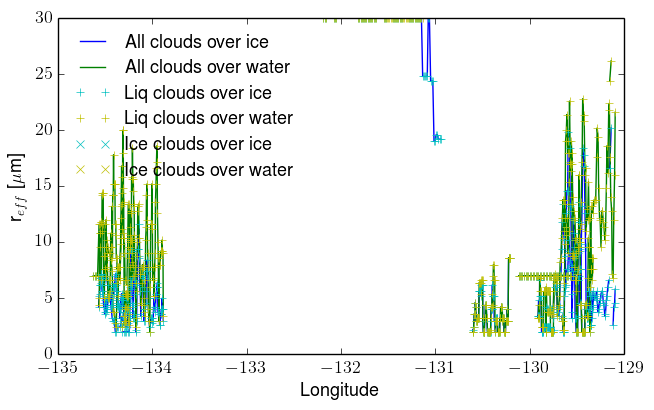

In [90]:
plt.plot(stars.lon,stars.iceref,label='All clouds over ice')
plt.plot(stars.lon,stars.watref,label='All clouds over water')
plt.plot(stars.lon[stars.icephase==0],stars.iceref[stars.icephase==0],'c+',label='Liq clouds over ice')
plt.plot(stars.lon[stars.watphase==0],stars.watref[stars.watphase==0],'y+',label='Liq clouds over water')
plt.plot(stars.lon[stars.icephase==1],stars.iceref[stars.icephase==1],'cx',label='Ice clouds over ice')
plt.plot(stars.lon[stars.watphase==1],stars.watref[stars.watphase==1],'yx',label='Ice clouds over water')
plt.ylabel('r$_{eff}$ [$\\mu$m]')
plt.xlabel('Longitude')
plt.legend(frameon=False,loc=2)

## Now save the retrieved cloud values

In [38]:
import cPickle as pickle

In [41]:
import hdf5storage as hs

In [39]:
mdict = {'stars':stars,'aqua':aqua,'terra':terra}

In [42]:
fp_out = fp+'retr_sav.mat'
hs.savemat(fp_out,mdict)

NotImplementedError: Dictionaries with non-unicode keys are not supported: 'tau'

In [46]:
fpp_out = fp+'retr_sav.p'
pickle.dump(mdict,open(fpp_out,"wb"))

### Compile into statistics over water and over ice

In [47]:
fltice = np.where(stars.lon<-132.0)[0]
fltwat = np.where(stars.lon>-131.0)[0]

In [48]:
(stars.wattaumask,stars.iwattau) = Sp.nanmasked(stars.wattau[fltwat])
(stars.icetaumask,stars.iicetau) = Sp.nanmasked(stars.icetau[fltice])

In [54]:
def data2figpoints(x,dx):
    "function to tranform data locations to relative figure coordinates (in fractions of total figure"
    flen = fig.transFigure.transform([1,1])
    bot = ax1.transAxes.transform([0,0])/flen
    top = ax1.transAxes.transform([1,1])/flen
    
    start = ax1.transData.transform([x,0])/flen
    end = ax1.transData.transform([x+dx,0])/flen
    left = start[0]
    bottom = bot[1]
    width = end[0]-start[0]
    height = top[1]-bot[1] 
    return left,bottom,width,height

In [101]:
def plot_vert_hist(fig,y,pos,ylim,color='grey',label=None,legend=False,onlyhist=True,loc=2):
    "function to plot a 'bean' like vertical histogram"
    import Sp_parameters as Sp
    (ymask,iy) = Sp.nanmasked(y)
    ax = fig.add_axes(data2figpoints(pos,0.4),frameon=False,ylim=ylim)
    ax.tick_params(axis='both', which='both', labelleft='off', labelright='off',bottom='off',top='off',
               labelbottom='off',labeltop='off',right='off',left='off')
    ax.hist(ymask,orientation='horizontal',normed=True,color=color,edgecolor='None',bins=30,alpha=0.5,label=label)
    if onlyhist:
        label_mean = None
        label_median = None
    else:
        label_mean = 'Mean'
        label_median = 'Median'
    ax.axhline(mean(ymask),color='red',linewidth=2,label=label_mean)
    ax.axhline(median(ymask),color='k',linewidth=2,linestyle='--',label=label_median)
    if legend:
        ax.legend(frameon=False,loc=loc)
    ax = fig.add_axes(data2figpoints(pos+0.01,-0.4),frameon=False,ylim=ylim)
    ax.tick_params(axis='both', which='both', labelleft='off', labelright='off',bottom='off',top='off',
                   labelbottom='off',labeltop='off',right='off',left='off')
    ax.hist(ymask,orientation='horizontal',normed=True,color=color,edgecolor='None',bins=30,alpha=0.5)
    ax.axhline(mean(ymask),color='red',linewidth=2)
    ax.axhline(median(ymask),color='k',linewidth=2,linestyle='--')

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\matplotlib\axes.py:8262: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 0 x 1)
  'this looks transposed (shape is %d x %d)' % x.shape[::-1])


ValueError: zero-size array to reduction operation minimum which has no identity

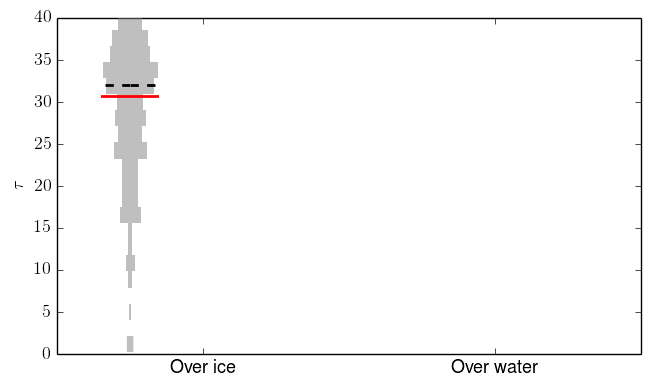

In [56]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,40],xlim=[-1,7])
ax1.set_ylabel('$\\tau$')
ax1.set_xticks([1,5])
ax1.set_xticklabels(['Over ice','Over water'])
plot_vert_hist(fig,stars.icetau[fltice],0,[0,40],color='grey',label='Total')
plot_vert_hist(fig,stars.icetau[fltice[stars.icephase[fltice]==1]],1,[0,40],color='red',label='Ice')
plot_vert_hist(fig,stars.icetau[fltice[stars.icephase[fltice]==0]],2,[0,40],color='blue',label='Liquid')
ax.legend()

plot_vert_hist(fig,stars.wattau[fltwat],4,[0,40],color='grey')
plot_vert_hist(fig,stars.wattau[fltwat[stars.watphase[fltwat]==1]],5,[0,40],color='red')
plot_vert_hist(fig,stars.wattau[fltwat[stars.watphase[fltwat]==0]],6,[0,40],color='blue')
ax1.set_title('Distribution of $\\tau$ over different surfaces')
plt.savefig(fp+'plots/20140919_pdf_surf_tau.png',dpi=600,transparent=True)

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,60],xlim=[-1,7])
ax1.set_ylabel('r$_{eff}$ [$\\mu$m]')
ax1.set_xticks([1,5])
ax1.set_xticklabels(['Over ice','Over water'])
plot_vert_hist(fig,stars.iceref[fltice],0,[0,60],color='grey',label='Total')
plot_vert_hist(fig,stars.iceref[fltice[stars.icephase[fltice]==1]],1,[0,60],color='red',label='Ice')
plot_vert_hist(fig,stars.iceref[fltice[stars.icephase[fltice]==0]],2,[0,60],color='blue',label='Liquid')

plot_vert_hist(fig,stars.watref[fltwat],4,[0,60],color='grey')
plot_vert_hist(fig,stars.watref[fltwat[stars.watphase[fltwat]==1]],5,[0,60],color='red')
plot_vert_hist(fig,stars.watref[fltwat[stars.watphase[fltwat]==0]],6,[0,60],color='blue')
ax1.set_title('Distribution of Effective Radius over different surfaces')
plt.savefig(fp+'plots/20140919_pdf_surf_ref.png',dpi=600,transparent=True)

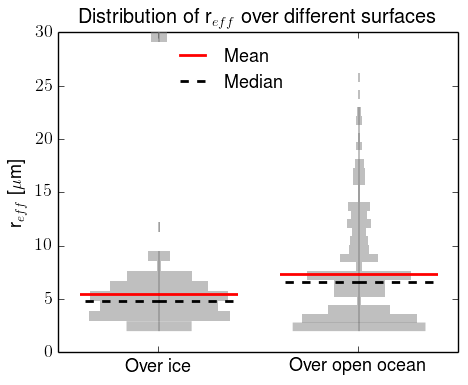

In [118]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,30],xlim=[0,2])
ax1.set_ylabel('r$_{eff}$ [$\\mu$m]')
ax1.set_xticks([0.5,1.5])
ax1.set_xticklabels(['Over ice','Over open ocean'])
plot_vert_hist(fig,stars.iceref[fltice],0.5,[0,30],color='grey',legend=True,onlyhist=False)
plot_vert_hist(fig,stars.watref[fltwat],1.5,[0,30],color='grey')

ax1.set_title('Distribution of r$_{eff}$ over different surfaces')
plt.savefig(fp+'plots/20140919_pdf_surf_tot_ref_forceliq.png',dpi=600,transparent=True)

In [138]:
print np.nanmean(stars.iceref[fltice])
print np.nanmean(stars.watref[fltwat])
print np.nanmean(stars.watref[fltwat])-np.nanmean(stars.iceref[fltice])
print np.nanmean(stars.watref[fltwat])-np.nanmean(stars.iceref[fltice])/np.nanmean(stars.watref[fltwat])*100.0

5.50553191489
7.3286908078
1.82315889291
-67.7943026337


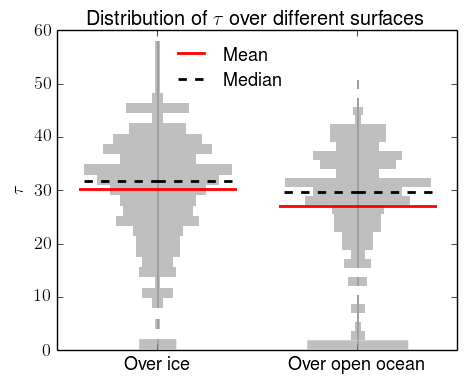

In [119]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,60],xlim=[0,2])
ax1.set_ylabel('$\\tau$')
ax1.set_xticks([0.5,1.5])
ax1.set_xticklabels(['Over ice','Over open ocean'])
plot_vert_hist(fig,stars.icetau[fltice],0.5,[0,60],color='grey',legend=True,onlyhist=False)
plot_vert_hist(fig,stars.wattau[fltwat],1.5,[0,60],color='grey')
ax1.set_title('Distribution of $\\tau$ over different surfaces')
plt.savefig(fp+'plots/20140919_pdf_surf_tot_tau_forceliq.png',dpi=600,transparent=True)

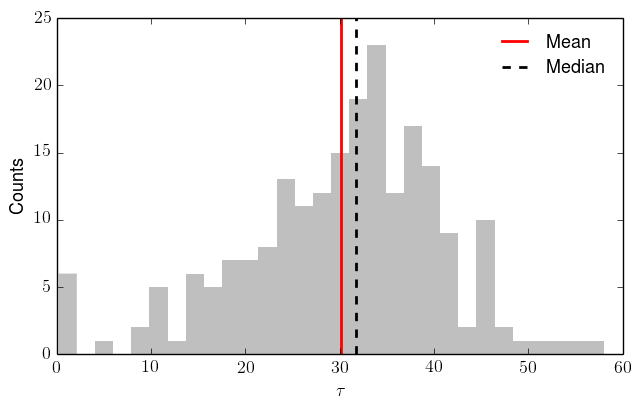

In [120]:
ntau,intau = Sp.nanmasked(stars.icetau[fltice])
plt.figure()
plt.hist(ntau,bins=30,color='grey',edgecolor='None',alpha=0.5)
plt.xlim([0,60])
plt.xlabel('$\\tau$')
plt.ylabel('Counts')
plt.axvline(np.mean(ntau),color='r',label='Mean',linewidth=2)
plt.axvline(np.median(ntau),color='k',linestyle='--',label='Median',linewidth=2)
plt.legend(frameon=False)
plt.savefig(fp+'plots/20140919_hist_tau_forceliq.png',dpi=600,transparent=True)

In [100]:
print np.nanmean(stars.icetau[fltice])
print np.nanmean(stars.wattau[fltwat])
print np.nanmean(stars.wattau[fltwat])-np.nanmean(stars.icetau[fltice])
print (np.nanmean(stars.wattau[fltwat])-np.nanmean(stars.icetau[fltice]))/np.nanmean(stars.wattau[fltwat])*100.0

30.1844339625
27.0648611114
-3.11957285114
-11.5262843519


In [101]:
print np.nanmean(stars.iceref[fltice])
print np.nanmean(stars.watref[fltwat])
print np.nanmean(stars.watref[fltwat])-np.nanmean(stars.iceref[fltice])
print (np.nanmean(stars.watref[fltwat])-np.nanmean(stars.iceref[fltice]))/np.nanmean(stars.watref[fltwat])*100.0

5.50553191489
7.3286908078
1.82315889291
24.8770065585


Plotting the over ice, tau and reff together, and also over ocean tau and ref together

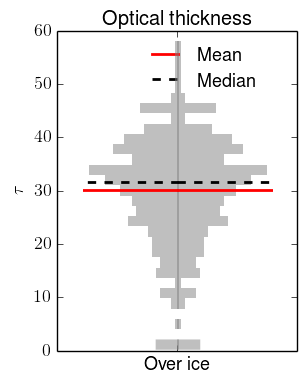

In [122]:
fig = plt.figure(figsize=(3,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,60],xlim=[0.5,1.5])
ax1.set_ylabel('$\\tau$')
ax1.set_xticks([1])
ax1.set_xticklabels(['Over ice'])
plot_vert_hist(fig,stars.icetau[fltice],1,[0,60],color='grey',legend=True,onlyhist=False,loc=1)
#plot_vert_hist(fig,stars.wattau[fltwat],1.5,[0,40],color='grey')
ax1.set_title('Optical thickness')
plt.savefig(fp+'plots/20140919_hist_tau_over_ice_forceliq.png',dpi=600,transparent=True)

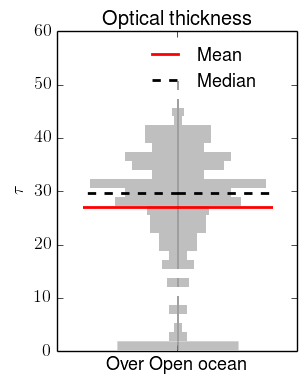

In [123]:
fig = plt.figure(figsize=(3,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,60],xlim=[0.5,1.5])
ax1.set_ylabel('$\\tau$')
ax1.set_xticks([1])
ax1.set_xticklabels(['Over Open ocean'])
#plot_vert_hist(fig,stars.icetau[fltice],1,[0,40],color='grey',legend=True,onlyhist=False,loc=1)
plot_vert_hist(fig,stars.wattau[fltwat],1,[0,60],color='grey',legend=True,onlyhist=False,loc=1)
ax1.set_title('Optical thickness')
plt.savefig(fp+'plots/20140919_hist_tau_over_ocean_forceliq.png',dpi=600,transparent=True)

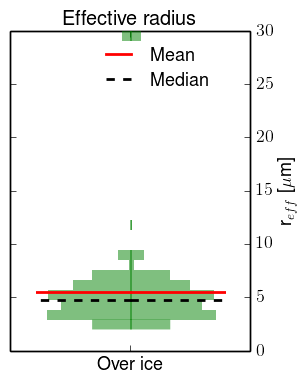

In [124]:
fig = plt.figure(figsize=(3,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,30],xlim=[0.5,1.5])
ax2 = ax1.twinx()
ax2.set_ylabel('r$_{eff}$ [$\\mu$m]')
ax2.set_ylim(ax1.get_ylim())
ax1.set_xticks([1])
ax1.set_xticklabels(['Over ice'])
ax1.tick_params(axis='y',which='both',labelleft='off', labelright='off')
ax2.tick_params(axis='both', which='both', labelleft='off', labelright='on',bottom='on',top='off',
               labelbottom='on',labeltop='off',right='on',left='off')
plot_vert_hist(fig,stars.iceref[fltice],1,[0,30],color='green',legend=True,onlyhist=False,loc=1)
#plot_vert_hist(fig,stars.wattau[fltwat],1.5,[0,40],color='grey')
ax1.set_title('Effective radius')
plt.savefig(fp+'plots/20140919_hist_ref_over_ice_forceliq.png',dpi=600,transparent=True)

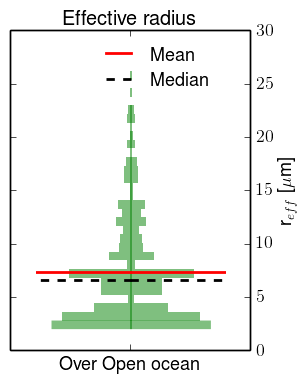

In [125]:
fig = plt.figure(figsize=(3,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,30],xlim=[0.5,1.5])
ax2 = ax1.twinx()
ax2.set_ylabel('r$_{eff}$ [$\\mu$m]')
ax2.set_ylim(ax1.get_ylim())
ax1.set_xticks([1])
ax1.set_xticklabels(['Over Open ocean'])
ax1.tick_params(axis='y',which='both',labelleft='off', labelright='off')
ax2.tick_params(axis='both', which='both', labelleft='off', labelright='on',bottom='on',top='off',
               labelbottom='on',labeltop='off',right='on',left='off')
#plot_vert_hist(fig,stars.iceref[fltice],1,[0,60],color='green',legend=True,onlyhist=False,loc=1)
plot_vert_hist(fig,stars.watref[fltwat],1,[0,30],color='green',legend=True,onlyhist=False,loc=1)
ax1.set_title('Effective radius')
plt.savefig(fp+'plots/20140919_hist_ref_over_ocean_forceliq.png',dpi=600,transparent=True)

Testing other types of plots

In [106]:
import statsmodels.api as sm

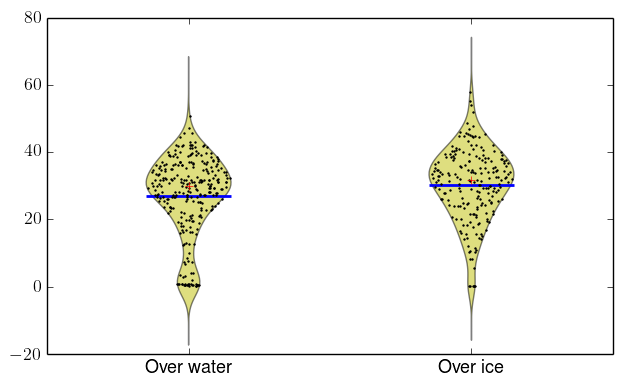

In [107]:
fig = sm.graphics.beanplot([stars.wattaumask,stars.icetaumask],
                           labels=['Over water','Over ice'],
                           jitter=True,
                           plot_opts={'jitter_marker':'+','jitter_marker_size':2})

## Now Match MODIS points to flight path

In [49]:
aqua.keys()

['tau',
 'etau',
 'multi_layer',
 'sza',
 'lon',
 'qa',
 'phase',
 'eref',
 'lat',
 'ref']

In [50]:
aqua['lon'].shape

(2030L, 1354L)

In [55]:
ind_aqua = np.zeros((2,len(path_lat)), dtype=np.int)
for i,x in enumerate(path_lat):
    y = path_lon[i]
    ind_aqua[:,i] = np.unravel_index(np.nanargmin(np.square(aqua['lat']-x)+np.square(aqua['lon']-y)),aqua['lat'].shape)

In [56]:
ind_terra = np.zeros((2,len(path_lat)), dtype=np.int)
for i,x in enumerate(path_lat):
    y = path_lon[i]
    ind_terra[:,i] = np.unravel_index(np.nanargmin(np.square(terra['lat']-x)+np.square(terra['lon']-y)),terra['lat'].shape)

## Plotting resulting MODIS cloud properties

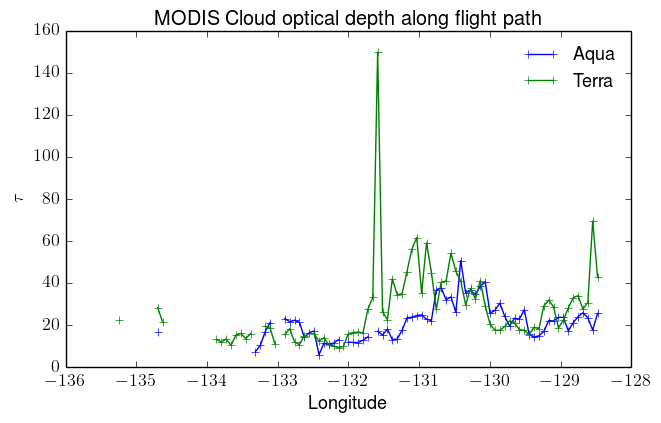

In [112]:
plt.plot(path_lon,aqua['tau'][ind_aqua[0,:],ind_aqua[1,:]],'b+-',label='Aqua')
plt.plot(path_lon,terra['tau'][ind_terra[0,:],ind_terra[1,:]],'g+-',label='Terra')
plt.legend(frameon=False)
plt.ylabel('$\\tau$')
plt.xlabel('Longitude')
plt.title('MODIS Cloud optical depth along flight path')

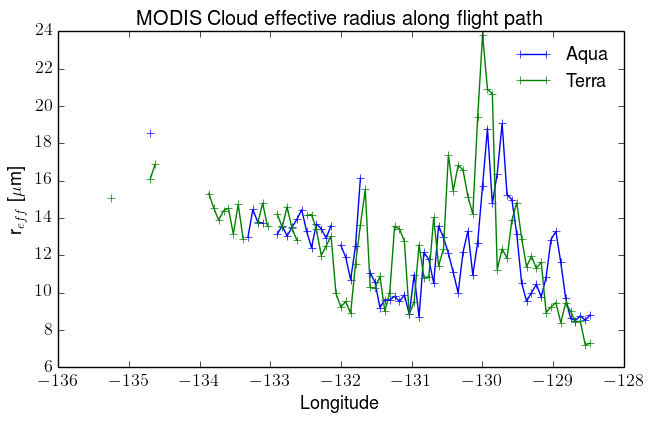

In [113]:
plt.plot(path_lon,aqua['ref'][ind_aqua[0,:],ind_aqua[1,:]],'b+-',label='Aqua')
plt.plot(path_lon,terra['ref'][ind_terra[0,:],ind_terra[1,:]],'g+-',label='Terra')
plt.legend(frameon=False)
plt.ylabel('r$_{eff}$ [$\\mu$m]')
plt.xlabel('Longitude')
plt.title('MODIS Cloud effective radius along flight path')

In [57]:
pathice = np.where(path_lon<-132.0)[0]
pathwat = np.where(path_lon>-131.0)[0]

## Build MODIS and 4STAR comparison plot

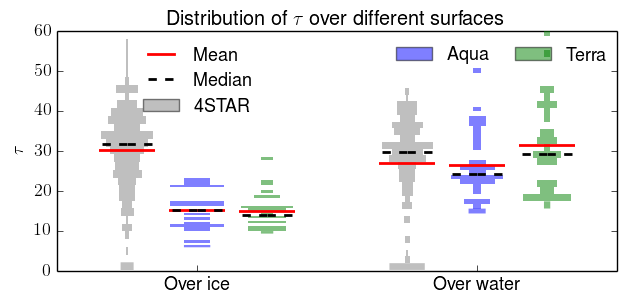

In [126]:
fig = plt.figure(figsize=(7,3))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,60],xlim=[-1,7])
ax1.set_ylabel('$\\tau$')
ax1.set_xticks([1,5])
ax1.set_xticklabels(['Over ice','Over water'])
ax1.tick_params(axis='x', which='both', top='off')
plot_vert_hist(fig,stars.icetau[fltice],0,[0,60],color='grey',label='4STAR',legend=True,onlyhist=False,loc=2)
plot_vert_hist(fig,aqua['tau'][ind_aqua[0,pathice],ind_aqua[1,pathice]],1,[0,60],color='blue')
plot_vert_hist(fig,terra['tau'][ind_terra[0,pathice],ind_terra[1,pathice]],2,[0,60],color='green')

plot_vert_hist(fig,stars.wattau[fltwat],4,[0,60],color='grey')
plot_vert_hist(fig,aqua['tau'][ind_aqua[0,pathwat],ind_aqua[1,pathwat]],5,[0,60],color='blue',label='Aqua',legend=True,loc=1)
plot_vert_hist(fig,terra['tau'][ind_terra[0,pathwat],ind_terra[1,pathwat]],6,[0,60],color='green',label='Terra',legend=True,loc=9)
ax1.set_title('Distribution of $\\tau$ over different surfaces')
plt.savefig(fp+'plots/20140919_comp_modis_tau_forceliq.png',dpi=600,transparent=True)

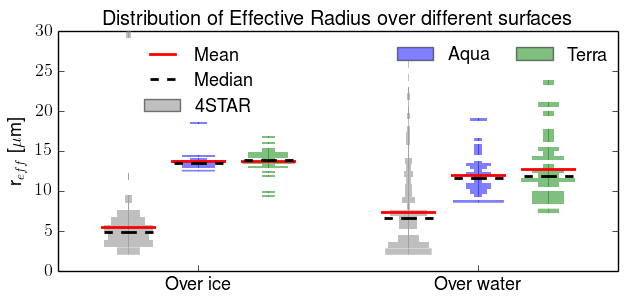

In [127]:
fig = plt.figure(figsize=(7,3))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,30],xlim=[-1,7])
ax1.set_ylabel('r$_{eff}$ [$\\mu$m]')
ax1.set_xticks([1,5])
ax1.set_xticklabels(['Over ice','Over water'])
ax1.tick_params(axis='x', which='both', top='off')
plot_vert_hist(fig,stars.iceref[fltice],0,[0,30],color='grey',label='4STAR',legend=True,onlyhist=False,loc=2)
plot_vert_hist(fig,aqua['ref'][ind_aqua[0,pathice],ind_aqua[1,pathice]],1,[0,30],color='blue')
plot_vert_hist(fig,terra['ref'][ind_terra[0,pathice],ind_terra[1,pathice]],2,[0,30],color='green')

plot_vert_hist(fig,stars.watref[fltwat],4,[0,30],color='grey')
plot_vert_hist(fig,aqua['ref'][ind_aqua[0,pathwat],ind_aqua[1,pathwat]],5,[0,30],color='blue',label='Aqua',legend=True,loc=1)
plot_vert_hist(fig,terra['ref'][ind_terra[0,pathwat],ind_terra[1,pathwat]],6,[0,30],color='green',label='Terra',legend=True,loc=9)
ax1.set_title('Distribution of Effective Radius over different surfaces')
plt.savefig(fp+'plots/20140919_comp_modis_ref_forceliq.png',dpi=600,transparent=True)

## Compile the values of downwelling and upwelling irradiance linked to the cloud properties

### Do the over water first

In [68]:
waq_dn = np.zeros_like(aqua['ref'][ind_aqua[0,pathwat],ind_aqua[1,pathwat]])
wte_dn = np.zeros_like(terra['ref'][ind_terra[0,pathwat],ind_terra[1,pathwat]])
wst_dn = np.zeros_like(stars.watref[fltwat])
waq_up = np.zeros_like(aqua['ref'][ind_aqua[0,pathwat],ind_aqua[1,pathwat]])
wte_up = np.zeros_like(terra['ref'][ind_terra[0,pathwat],ind_terra[1,pathwat]])
wst_up = np.zeros_like(stars.watref[fltwat])

In [70]:
waq_dncl = np.zeros_like(aqua['ref'][ind_aqua[0,pathwat],ind_aqua[1,pathwat]])
wte_dncl = np.zeros_like(terra['ref'][ind_terra[0,pathwat],ind_terra[1,pathwat]])
wst_dncl = np.zeros_like(stars.watref[fltwat])
waq_upcl = np.zeros_like(aqua['ref'][ind_aqua[0,pathwat],ind_aqua[1,pathwat]])
wte_upcl = np.zeros_like(terra['ref'][ind_terra[0,pathwat],ind_terra[1,pathwat]])
wst_upcl = np.zeros_like(stars.watref[fltwat])

In [97]:
waq_cre = np.zeros_like(aqua['ref'][ind_aqua[0,pathwat],ind_aqua[1,pathwat]])
waq_rcre = np.zeros_like(aqua['ref'][ind_aqua[0,pathwat],ind_aqua[1,pathwat]])
wte_cre = np.zeros_like(terra['ref'][ind_terra[0,pathwat],ind_terra[1,pathwat]])
wst_cre = np.zeros_like(stars.watref[fltwat])
wte_rcre = np.zeros_like(terra['ref'][ind_terra[0,pathwat],ind_terra[1,pathwat]])
wst_rcre = np.zeros_like(stars.watref[fltwat])

In [66]:
#do over water
print swat['sp_irrdn'].shape
print 'sp (wp, wvl, z, re, ta)'

(2L, 1556L, 2L, 35L, 24L)
sp (wp, wvl, z, re, ta)


In [90]:
def get_rad_close(s,wvl,p,z,t,r):
    it = np.argmin(abs(swat['tau']-t))
    ir = np.argmin(abs(swat['ref']-r))
    return np.sum(s[p,250:,z,it,ir]*wvl[250:]/1000.0)

In [91]:
ref_dn = get_rad_close(swat['sp_irrdn'],swat['zenlambda'],0,1,0,0)

In [106]:
for i,t in enumerate(aqua['tau'][ind_aqua[0,pathwat],ind_aqua[1,pathwat]]):
    r = aqua['ref'][ind_aqua[0,pathwat],ind_aqua[1,pathwat]][i]
    waq_dn[i] = get_rad_close(swat['sp_irrdn'],swat['zenlambda'],0,0,t,r)
    waq_up[i] = get_rad_close(swat['sp_irrup'],swat['zenlambda'],0,0,t,r)
    waq_dncl[i] = get_rad_close(swat['sp_irrdn'],swat['zenlambda'],0,0,0,0)
    waq_upcl[i] = get_rad_close(swat['sp_irrup'],swat['zenlambda'],0,0,0,0)
    waq_cre[i] = (waq_dn[i]-waq_up[i])-(waq_dncl[i]-waq_upcl[i])
    waq_rcre[i] = waq_cre[i]/ref_dn*100.0

In [107]:
for i,t in enumerate(terra['tau'][ind_terra[0,pathwat],ind_terra[1,pathwat]]):
    r = terra['ref'][ind_terra[0,pathwat],ind_terra[1,pathwat]][i]
    wte_dn[i] = get_rad_close(swat['sp_irrdn'],swat['zenlambda'],0,0,t,r)
    wte_up[i] = get_rad_close(swat['sp_irrup'],swat['zenlambda'],0,0,t,r)
    wte_dncl[i] = get_rad_close(swat['sp_irrdn'],swat['zenlambda'],0,0,0,0)
    wte_upcl[i] = get_rad_close(swat['sp_irrup'],swat['zenlambda'],0,0,0,0)
    wte_cre[i] = (wte_dn[i]-wte_up[i])-(wte_dncl[i]-wte_upcl[i])
    wte_rcre[i] = wte_cre[i]/ref_dn*100.0

In [108]:
for i,t in enumerate(stars.wattau[fltwat]):
    r = stars.watref[fltwat][i]
    wst_dn[i] = get_rad_close(swat['sp_irrdn'],swat['zenlambda'],0,0,t,r)
    wst_up[i] = get_rad_close(swat['sp_irrup'],swat['zenlambda'],0,0,t,r)
    wst_dncl[i] = get_rad_close(swat['sp_irrdn'],swat['zenlambda'],0,0,0,0)
    wst_upcl[i] = get_rad_close(swat['sp_irrup'],swat['zenlambda'],0,0,0,0)
    wst_cre[i] = (wst_dn[i]-wst_up[i])-(wst_dncl[i]-wst_upcl[i])
    wst_rcre[i] = wst_cre[i]/ref_dn*100.0

In [102]:
import plotting_utils as pu

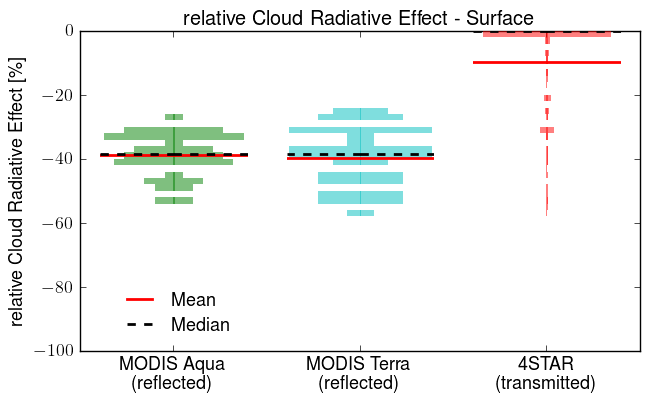

In [111]:
fig = plt.figure(figsize=(7,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[-100,0],xlim=[-0.5,2.5])
ax1.set_ylabel('relative Cloud Radiative Effect [\%]')
ax1.set_title('relative Cloud Radiative Effect - Surface')
ax1.set_xticks([0,1,2])
ax1.set_xticklabels(['MODIS Aqua\n(reflected)','MODIS Terra\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,waq_rcre,0,[-100,0],legend=True,onlyhist=False,loc=4,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,wte_rcre,1,[-100,0],legend=True,color='c',bins=50)
pu.plot_vert_hist(fig,ax1,wst_rcre,2,[-100,0],legend=True,color='r',bins=50)
plt.savefig(fp+'plots/rcre_water.png',dpi=600,transparent=True)

In [112]:
np.nanmean(waq_rcre), np.nanmean(wte_rcre),np.nanmean(wst_rcre)

(-38.817111489589955, -39.611604925099648, -9.7067529805141213)

In [113]:
np.nanstd(waq_rcre), np.nanstd(wte_rcre),np.nanstd(wst_rcre)

(6.5614759274825882, 8.8379885902639437, 15.963943818857958)

### Do over ice now

In [117]:
iaq_dn = np.zeros_like(aqua['ref'][ind_aqua[0,pathice],ind_aqua[1,pathice]])
ite_dn = np.zeros_like(terra['ref'][ind_terra[0,pathice],ind_terra[1,pathice]])
ist_dn = np.zeros_like(stars.watref[fltice])
iaq_up = np.zeros_like(aqua['ref'][ind_aqua[0,pathice],ind_aqua[1,pathice]])
ite_up = np.zeros_like(terra['ref'][ind_terra[0,pathice],ind_terra[1,pathice]])
ist_up = np.zeros_like(stars.watref[fltice])

In [118]:
iaq_dncl = np.zeros_like(aqua['ref'][ind_aqua[0,pathice],ind_aqua[1,pathice]])
ite_dncl = np.zeros_like(terra['ref'][ind_terra[0,pathice],ind_terra[1,pathice]])
ist_dncl = np.zeros_like(stars.watref[fltice])
iaq_upcl = np.zeros_like(aqua['ref'][ind_aqua[0,pathice],ind_aqua[1,pathice]])
ite_upcl = np.zeros_like(terra['ref'][ind_terra[0,pathice],ind_terra[1,pathice]])
ist_upcl = np.zeros_like(stars.watref[fltice])

In [119]:
iaq_cre = np.zeros_like(aqua['ref'][ind_aqua[0,pathice],ind_aqua[1,pathice]])
iaq_rcre = np.zeros_like(aqua['ref'][ind_aqua[0,pathice],ind_aqua[1,pathice]])
ite_cre = np.zeros_like(terra['ref'][ind_terra[0,pathice],ind_terra[1,pathice]])
ist_cre = np.zeros_like(stars.watref[fltice])
ite_rcre = np.zeros_like(terra['ref'][ind_terra[0,pathice],ind_terra[1,pathice]])
ist_rcre = np.zeros_like(stars.watref[fltice])

In [120]:
#do over water
print sice['sp_irrdn'].shape
print 'sp (wp, wvl, z, re, ta)'

(2L, 1556L, 2L, 35L, 24L)
sp (wp, wvl, z, re, ta)


In [121]:
def get_rad_close(s,wvl,p,z,t,r):
    it = np.argmin(abs(sice['tau']-t))
    ir = np.argmin(abs(sice['ref']-r))
    return np.sum(s[p,250:,z,it,ir]*wvl[250:]/1000.0)

In [138]:
ref_dn = get_rad_close(sice['sp_irrdn'],sice['zenlambda'],0,1,0,0)

In [139]:
for i,t in enumerate(aqua['tau'][ind_aqua[0,pathice],ind_aqua[1,pathice]]):
    r = aqua['ref'][ind_aqua[0,pathice],ind_aqua[1,pathice]][i]
    iaq_dn[i] = get_rad_close(sice['sp_irrdn'],sice['zenlambda'],0,0,t,r)
    iaq_up[i] = get_rad_close(sice['sp_irrup'],sice['zenlambda'],0,0,t,r)
    iaq_dncl[i] = get_rad_close(sice['sp_irrdn'],sice['zenlambda'],0,0,0,0)
    iaq_upcl[i] = get_rad_close(sice['sp_irrup'],sice['zenlambda'],0,0,0,0)
    iaq_cre[i] = (iaq_dn[i]-iaq_up[i])-(iaq_dncl[i]-iaq_upcl[i])
    iaq_rcre[i] = iaq_cre[i]/ref_dn*100.0

In [140]:
for i,t in enumerate(terra['tau'][ind_terra[0,pathice],ind_terra[1,pathice]]):
    r = terra['ref'][ind_terra[0,pathice],ind_terra[1,pathice]][i]
    ite_dn[i] = get_rad_close(sice['sp_irrdn'],sice['zenlambda'],0,0,t,r)
    ite_up[i] = get_rad_close(sice['sp_irrup'],sice['zenlambda'],0,0,t,r)
    ite_dncl[i] = get_rad_close(sice['sp_irrdn'],sice['zenlambda'],0,0,0,0)
    ite_upcl[i] = get_rad_close(sice['sp_irrup'],sice['zenlambda'],0,0,0,0)
    ite_cre[i] = (ite_dn[i]-ite_up[i])-(ite_dncl[i]-ite_upcl[i])
    ite_rcre[i] = ite_cre[i]/ref_dn*100.0

In [141]:
for i,t in enumerate(stars.icetau[fltice]):
    r = stars.iceref[fltice][i]
    ist_dn[i] = get_rad_close(sice['sp_irrdn'],sice['zenlambda'],0,0,t,r)
    ist_up[i] = get_rad_close(sice['sp_irrup'],sice['zenlambda'],0,0,t,r)
    ist_dncl[i] = get_rad_close(sice['sp_irrdn'],sice['zenlambda'],0,0,0,0)
    ist_upcl[i] = get_rad_close(sice['sp_irrup'],sice['zenlambda'],0,0,0,0)
    ist_cre[i] = (ist_dn[i]-ist_up[i])-(ist_dncl[i]-ist_upcl[i])
    ist_rcre[i] = ist_cre[i]/ref_dn*100.0

In [142]:
import plotting_utils as pu

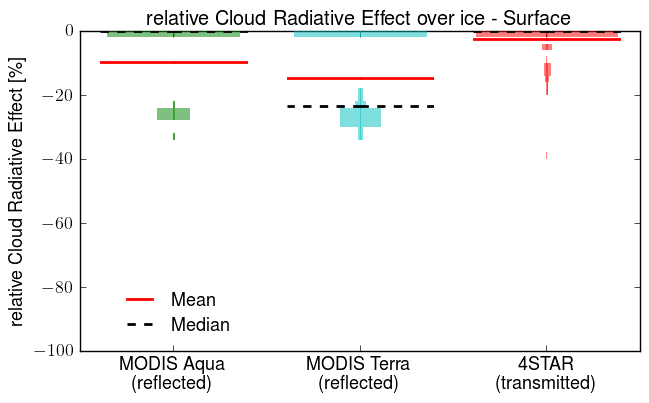

In [143]:
fig = plt.figure(figsize=(7,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[-100,0],xlim=[-0.5,2.5])
ax1.set_ylabel('relative Cloud Radiative Effect [\%]')
ax1.set_title('relative Cloud Radiative Effect over ice - Surface')
ax1.set_xticks([0,1,2])
ax1.set_xticklabels(['MODIS Aqua\n(reflected)','MODIS Terra\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,iaq_rcre,0,[-100,0],legend=True,onlyhist=False,loc=4,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,ite_rcre,1,[-100,0],legend=True,color='c',bins=50)
pu.plot_vert_hist(fig,ax1,ist_rcre,2,[-100,0],legend=True,color='r',bins=50)
plt.savefig(fp+'plots/rcre_ice.png',dpi=600,transparent=True)

In [130]:
np.nanmean(iaq_rcre), np.nanmean(ite_rcre),np.nanmean(ist_rcre)

(-9.7862021584847554, -14.801675256730379, -2.6911180399285071)

In [131]:
np.nanstd(iaq_rcre), np.nanstd(ite_rcre),np.nanstd(ist_rcre)

(12.901037427333174, 13.542785023247793, 5.5873124946413864)

# Run the advanced miscrophysics analysis

## Compare to $r_{eff}$ derived from Cloud probes

In [130]:
probe.dtype.names

('UTC_mid',
 'Latitude_deg',
 'Longitude_deg',
 'PressAlt_ft',
 'TWC_gm3',
 'LWC1_gm3',
 'LWC2_gm3',
 'PWV_cm',
 'LWP_mm',
 'Tb1_degC',
 'Tb3_degC',
 'Tb7_degC',
 'Tb14_degC',
 'nCDP_cm3',
 'vCDP_um3cm3',
 'CDP01_dNdlogD',
 'CDP02_dNdlogD',
 'CDP03_dNdlogD',
 'CDP04_dNdlogD',
 'CDP05_dNdlogD',
 'CDP06_dNdlogD',
 'CDP07_dNdlogD',
 'CDP08_dNdlogD',
 'CDP09_dNdlogD',
 'CDP10_dNdlogD',
 'CDP11_dNdlogD',
 'CDP12_dNdlogD',
 'CDP13_dNdlogD',
 'CDP14_dNdlogD',
 'CDP15_dNdlogD',
 'CDP16_dNdlogD',
 'CDP17_dNdlogD',
 'CDP18_dNdlogD',
 'CDP19_dNdlogD',
 'CDP20_dNdlogD',
 'CDP21_dNdlogD',
 'CDP22_dNdlogD',
 'CDP23_dNdlogD',
 'CDP24_dNdlogD',
 'CDP25_dNdlogD',
 'CDP26_dNdlogD',
 'CDP27_dNdlogD',
 'CDP28_dNdlogD',
 'CDP29_dNdlogD',
 'CDP30_dNdlogD')

In [180]:
flt_probe_ice = np.where((probe['UTC_mid']>19.0) & (probe['UTC_mid']<23.0) & (probe['Longitude_deg']<-133.5))[0]
flt_probe_wat = np.where((probe['UTC_mid']>19.0) & (probe['UTC_mid']<23.0) & (probe['Longitude_deg']>-130.0))[0] 

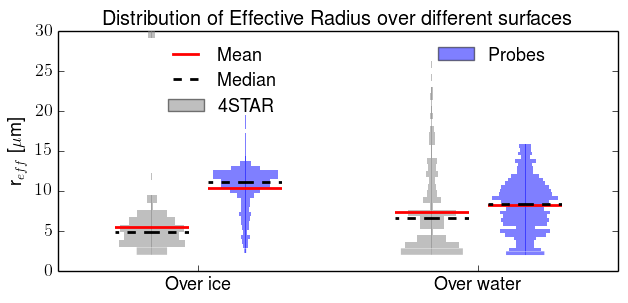

In [181]:
fig = plt.figure(figsize=(7,3))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,30],xlim=[-1,5])
ax1.set_ylabel('r$_{eff}$ [$\\mu$m]')
ax1.set_xticks([0.5,3.5])
ax1.set_xticklabels(['Over ice','Over water'])
ax1.tick_params(axis='x', which='both', top='off')
plot_vert_hist(fig,stars.iceref[fltice],0,[0,30],color='grey',label='4STAR',legend=True,onlyhist=False,loc=2)
plot_vert_hist(fig,probe_ref[flt_probe_ice],1,[0,30],color='blue')
#plot_vert_hist(fig,terra['ref'][ind_terra[0,pathice],ind_terra[1,pathice]],2,[0,30],color='green')

plot_vert_hist(fig,stars.watref[fltwat],3,[0,30],color='grey')
plot_vert_hist(fig,probe_ref[flt_probe_wat],4,[0,30],color='blue',label='Probes',legend=True,loc=1)
#plot_vert_hist(fig,aqua['ref'][ind_aqua[0,pathwat],ind_aqua[1,pathwat]],5,[0,30],color='blue',label='Aqua',legend=True,loc=1)
#plot_vert_hist(fig,terra['ref'][ind_terra[0,pathwat],ind_terra[1,pathwat]],6,[0,30],color='green',label='Terra',legend=True,loc=9)
ax1.set_title('Distribution of Effective Radius over different surfaces')
plt.savefig(fp+'plots/20140919_comp_probes_ref_forceliq.png',dpi=600,transparent=True)

# Testing different programs for metadata saving for pngs and python files

In [ ]:
def getname(): 
    import IPython
    IPython.display.display(IPython.display.Javascript('IPython.notebook.kernel.execute("theNotebookName = " + "\'"+IPython.notebook.notebook_name+"\'");'))
    IPython.display.display(IPython.display.Javascript('IPython.notebook.kernel.execute("theNotebookPath = " + "\'"+IPython.notebook.notebook_path+"\'");'))

In [ ]:
getname()
thisfilepath = os.getcwd()+os.path.sep+theNotebookPath+theNotebookName
print thisfilepath
fstat = os.stat(thisfilepath)
import datetime
time_of_mod = datetime.datetime.fromtimestamp(fstat.st_mtime).strftime('%Y-%m-%d %H:%M:%S.%f')
import getpass
user = getpass.getuser()

In [ ]:
def savemetapng(filein,Notebookname,Notes=None):
    from PIL import Image
    from PIL import PngImagePlugin
    import datetime
    import getpass
    import os
    
    metadata = dict()
    metadata['Created with'] = 'IPython'+os.sys.version
    metadata['Script Name'] = Notebookname
    metadata['Time created'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')
    metadata['Author'] = getpass.getuser()
    if Notes:
        metadata['Notes'] = Notes
    
    im = Image.open(filein)
    meta = PngImagePlugin.PngInfo()

    for x in metadata:
        meta.add_text(x, metadata[x])
    im.save(filein, "png", pnginfo=meta)